In [6]:
# disruption in a period, then return to normal state（done)

# for bigger difference visually, use ratio(assume normal state 1)
# sensitive analysis(partly done) now in a snipshot, maybe another plot style?
# larger agent size (area size)










In [1]:
import random
import numpy as np
import math
import mesa
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from mesa import Agent, Model
from mesa.time import BaseScheduler
from collections import deque
import pandas as pd
from SCN.agent import Order, Customer, Manufacturer, Supplier
from SCN.model import update_transport_cost_for_order, SupplyChainGridModel, calculate_unit_cost_window, calculate_ratio_window, haversine_km

D:\python\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df = pd.read_csv("SCN/supply_chain_data.csv")
df.rename(columns={"Stock levels": "inventory"}, inplace=True)
df["inventory"] = df["inventory"].apply(lambda x: math.ceil(x) if pd.notnull(x) else x)
df["Order quantities"] = df["Order quantities"].apply(lambda x: math.ceil(x) if pd.notnull(x) else x)
df = df[["inventory", "Order quantities"]]
inventory_count = df["inventory"].count()
order_qty_count = df["Order quantities"].count()
print("inventory 列数据个数（非空）:", inventory_count)
print("Order quantities 列数据个数（非空）:", order_qty_count)
print(df.head())
demands_list = df["Order quantities"].dropna().tolist()
inventory_list = df["inventory"].dropna().astype(int).tolist()
inventory_mean = df["inventory"].mean()
order_qty_mean = df["Order quantities"].mean()

print(f"Inventory 列的均值: {inventory_mean}")
print(f"Order quantities 列的均值: {order_qty_mean}")

inventory 列数据个数（非空）: 100
Order quantities 列数据个数（非空）: 100
   inventory  Order quantities
0         58                96
1         53                37
2          1                88
3         23                59
4          5                56
Inventory 列的均值: 47.77
Order quantities 列的均值: 49.22


In [4]:
cust_pos = [
    (34.077606, -117.240181), (20.210739, -64.370605),  (38.611774, -121.282867),
    (26.145800, -97.958252),  (34.748348, -77.428482),  (40.763580, -93.830040),
    (23.285648, -85.370613),  (40.508579, -88.982643),  (40.575642, -73.995209),
    (33.089520, -117.255203), (19.228659, -76.370560),  (18.212404, -81.037056),
    (29.696537, -95.645920),  (39.000355, -77.227814),  (41.274368, -111.962868),
    (30.216906, -86.370514),  (30.223112, -100.037056),  (28.261724, -102.370583),
    (21.203922, -76.370613),  (20.253136, -66.037064),  (30.181829, -81.741158),
    (18.260290, -77.370575),  (39.827408, -84.890228),  (35.078728, -120.203323),
    (31.743509, -106.304138), (40.706020, -84.086853),  (25.223833, -92.370514),
    (37.287724, -121.764404), (18.223146, -79.370567),  (42.892185, -83.862381),
    (39.681881, -75.644211),  (42.391102, -83.131218),  (26.359011, -66.078171),
    (33.087120, -96.823570),  (33.410011, -111.771797), (28.268904, -74.370522)
]

man_pos = [
    (33.676708, -117.921905), (21.412319, -82.692352),
    (30.686657, -73.375534),  (40.513103, -83.021828),
    (26.697084, -98.124062),  (37.312534, -111.870071)
]

sup_pos = [
    (22.496193, -88.990883),  (30.258694, -97.766251),
    (40.675449, -73.811142),  (20.280403, -66.370575),
    (39.746620, -94.816437), (25.740225, -80.361694),
    (30.262302, -71.037056),  (29.827169, -95.501747),
    (20.224937, -80.037048),  (34.238966, -66.370621),
    (35.950428, -115.129326), (27.290588, -66.037064),
    (40.050499, -87.989975),  (39.941486, -82.002220),
]

In [5]:
import networkx as nx

'''def get_weighted_edge_count(model):
    """
    构建一个 MultiGraph，将模型中所有代理作为节点，
    对于每个 delivered_orders 中已完成且已发货的订单，
    在发货方和收货方之间添加一条边，边的权重为订单数量。
    返回图中所有边的权重和，即为 weighted edge count。
    """
    G = nx.MultiGraph()
    for agent in model.schedule.agents:
        G.add_node(agent.unique_id)
    for order in model.delivered_orders:
        if order.completed and order.shipped and order.order_type == "product":
            # 添加边时指定 weight 属性为订单数量
            G.add_edge(order.sender_id, order.receiver_id, weight=order.quantity)
    total_weight = sum(data.get('weight', 1) for u, v, data in G.edges(data=True))
    return total_weight'''
    
def get_weighted_edge_count(model, win=50):
    """
    统计最近 win 步窗口内（含当前步）完成的产品订单，
    以订单数量为权重汇总边数。
    """
    window_begin = model.schedule.steps - win
    G = nx.MultiGraph()

    # 把所有代理作为节点加入
    for agent in model.schedule.agents:
        G.add_node(agent.unique_id)

    # 只考虑窗口内完成、已发货、且类型为 product 的订单
    for order in model.delivered_orders:
        if (order.order_type == "product"
            and order.completed
            and order.shipped
            and order.completed_step > window_begin):          # 直接用 completed_step
            G.add_edge(order.sender_id,
                       order.receiver_id,
                       weight=order.quantity)

    # 汇总权重
    total_weight = sum(data["weight"] for _, _, data in G.edges(data=True))
    return total_weight

In [6]:
def run_simulation_with_param_changes(cust_positions=cust_pos,
        man_positions=man_pos,
        sup_positions=sup_pos,
        cust_demand_multiplier=1.0,
        m_production_capacity=150,
        m_inventory_capacity_product=400,
        m_inventory_capacity_material=800,
        s_material_capacity=140,
        agent_mode="heterogeneous",
        logistics_speed=1000,
        rm_procurement_mode="gap_based",
        rm_reorder_point=30,
        rm_reorder_target=500,
        rm_purchase_multiplier=1.1,
        rm_produce_multiplier=1.1,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=1000,
        num_reps=2,
        change_schedule=None,
        return_model=False,
        num_customers=36,
        num_manufacturers=6,
        num_suppliers=14
):
    """
    运行 num_reps 次仿真，并在运行过程中按 change_schedule 更新参数。
    返回：
        mean_prod_ratio:      平均时效比（可删）
        mean_unit_cost:       平均单位成本（可删）
        mean_edge_series:     每步平均加权边数
        std_edge_series:      每步加权边数标准差
        phase_metrics:        各阶段指标 (ratio, unit_cost, 完成量)
        mean_ratio_series:    每步平均时效比
        std_ratio_series:     每步时效比标准差
        mean_unit_cost_series: 每步平均单位成本
        std_unit_cost_series:  每步单位成本标准差
    """
    weighted_edge_count_list = []

    ratio_series_list = []
    unit_cost_series_list = []
    WIN = 100  

    for rep in range(num_reps):
        try:
            from SCN.agent import used_positions
            used_positions.clear()
        except:
            pass

        model = SupplyChainGridModel(
            cust_positions=cust_pos,
            man_positions=man_pos,
            sup_positions=sup_pos,
            demands_list=demands_list,
            inventory_list=inventory_list,
            num_customers=num_customers,
            num_manufacturers=num_manufacturers,
            num_suppliers=num_suppliers,
            cust_demand_probability=0.4,
            cust_demand_multiplier=cust_demand_multiplier,
            m_production_capacity=m_production_capacity,
            m_inventory_capacity_product=m_inventory_capacity_product,
            m_inventory_capacity_material=m_inventory_capacity_material,
            s_material_capacity=s_material_capacity,
            agent_mode=agent_mode,
            logistics_speed=logistics_speed,
            rm_procurement_mode=rm_procurement_mode,
            rm_reorder_point=rm_reorder_point,
            rm_reorder_target=rm_reorder_target,
            rm_purchase_multiplier=rm_purchase_multiplier,
            rm_produce_multiplier=rm_produce_multiplier,
            product_order_mode=product_order_mode,
            material_order_mode=material_order_mode
        )
        def _applicable(agents):
            # 如果是区域异质模式，只返回右侧 5 列的 agents，否则返回全部
            if model.agent_mode == "regional_heterogeneous":
                return [a for a in agents if a.pos[0] >= 35]
            else:
                return agents

        rep_edge_series = []
        rep_ratio_series = []
        rep_unit_cost_series = []

        if change_schedule:
            points = sorted(p for p in change_schedule if 0 < p <= total_steps)
        else:
            points = []
        points.append(total_steps)
        snapshots = [(0, 0, 0, 0)]
        next_change_index = 0

        for current_step in range(1, total_steps+1):
            model.step()

            # 记录 weighted edge count
            current_weighted_edge_count= get_weighted_edge_count(model,100)

            # 记录当前时效比 & 单位成本
            current_ratio = calculate_ratio_window(model, 100)
            current_uc    = calculate_unit_cost_window(model, 100)
            if current_uc is None:
                current_uc = 0 

            rep_ratio_series.append(current_ratio)
            rep_unit_cost_series.append(current_uc)
            rep_edge_series.append(current_weighted_edge_count)
            # 参数变更处理
            if change_schedule and current_step in change_schedule:
                changes = change_schedule[current_step]
                if "product_order_mode" in changes:
                    for c in _applicable(model.customers):
                        c.order_mode = changes["product_order_mode"]
                if "cust_demand_multiplier" in changes:
                    for c in _applicable(model.customers):
                        c.cust_demand_multiplier = changes["cust_demand_multiplier"]
                if "logistics_speed" in changes:
                    model.logistics_speed = changes["logistics_speed"]
                if "m_production_capacity" in changes:
                    for m in _applicable(model.manufacturers):
                        m.production_capacity = changes["m_production_capacity"]
                if "rm_procurement_mode" in changes:
                    for m in _applicable(model.manufacturers):
                        m.rm_procurement_mode = changes["rm_procurement_mode"]
                if "rm_purchase_multiplier" in changes:
                    for m in _applicable(model.manufacturers):
                        m.rm_purchase_multiplier = changes["rm_purchase_multiplier"]
                if "material_order_mode" in changes:
                    for m in _applicable(model.manufacturers):
                        m.material_order_mode = changes["material_order_mode"]
                if "m_inventory_capacity_material" in changes:
                    for m in _applicable(model.manufacturers):
                        m.inventory_capacity_material = changes["m_inventory_capacity_material"]
                if "m_inventory_capacity_product" in changes:
                    for m in _applicable(model.manufacturers):
                        m.inventory_capacity_product = changes["m_inventory_capacity_product"]
                if "s_material_capacity" in changes:
                    for s in _applicable(model.suppliers):
                        s.material_capacity = changes["s_material_capacity"]

    
        # 保存 rep 结果
        weighted_edge_count_list.append(rep_edge_series)
        ratio_series_list.append(rep_ratio_series)
        unit_cost_series_list.append(rep_unit_cost_series)


    # 计算跨 reps 的平均和 std
    edge_arr = np.array(weighted_edge_count_list)
    mean_edge = np.mean(edge_arr, axis=0)
    std_edge = np.std(edge_arr, axis=0)

    ratio_arr = np.array(ratio_series_list)
    mean_ratio = np.mean(ratio_arr, axis=0)
    std_ratio = np.std(ratio_arr, axis=0)

    uc_arr = np.array(unit_cost_series_list)
    mean_uc = np.mean(uc_arr, axis=0)
    std_uc = np.std(uc_arr, axis=0)

    results = (
        mean_edge,
        std_edge,
        mean_ratio,
        std_ratio,
        mean_uc,
        std_uc
    )
    return (model, results) if return_model else results

In [ ]:
# ##
change_schedule_A = {
    
}
total_steps = 2000

def run_scenario(scenario_name, change_schedule):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=920,
        m_inventory_capacity_material=1840,
        s_material_capacity=195,
        agent_mode="heterogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
        logistics_speed=500.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=1000,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=2000,
        num_reps=2,
        change_schedule=change_schedule,
        return_model=False,
        
        
    )
    # 这里 results = (mean_prod_ratio, mean_unit_cost, mean_weighted_edge_count)
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }
# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
start = 0 
time_steps = np.arange(1, total_steps + 1)

# 从各个策略的 simulation 返回结果中提取 weighted edge count 的均值和标准差
# 假设 run_scenario 返回的结果格式为：
# (mean_cap, mean_prod_ratio, mean_statusN, mean_unit_cost, mean_edge_series, std_edge_series)



# 绘制 Strategy A 的曲线和误差带

plt.figure(figsize=(10, 6))
plt.plot(time_steps[start:], results_A["mean_edge_series"][start:], label="Normal", color="blue")
plt.fill_between(time_steps[start:],
                 results_A["mean_edge_series"][start:] - results_A["std_edge_series"][start:],
                 results_A["mean_edge_series"][start:] + results_A["std_edge_series"][start:],
                 color="blue", alpha=0.2)


plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count over Time for Different Strategies\n(with Error Band: Mean ± STD)")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

# Fulfillment Ratio 曲线

plt.figure(figsize=(10, 6))
plt.plot(time_steps[start:], results_A["mean_ratio_series"][start:], label="Normal", color="blue")
plt.fill_between(time_steps[start:],
                 results_A["mean_ratio_series"][start:] - results_A["std_ratio_series"][start:],
                 results_A["mean_ratio_series"][start:] + results_A["std_ratio_series"][start:],
                 color="blue", alpha=0.2)



plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True)
plt.legend()
plt.ylim(bottom=0)
plt.show()

# Unit Cost 曲线

plt.figure(figsize=(10, 6))
plt.plot(time_steps[start:], results_A["mean_uc_series"][start:], label="Normal", color="blue")
plt.fill_between(time_steps[start:],
                 results_A["mean_uc_series"][start:] - results_A["std_uc_series"][start:],
                 results_A["mean_uc_series"][start:] + results_A["std_uc_series"][start:],
                 color="blue", alpha=0.2)



plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True)
plt.legend()
plt.ylim(bottom=0)
plt.show()

Running scenario: Strategy A
Running scenario: Strategy C
Running scenario: Strategy F


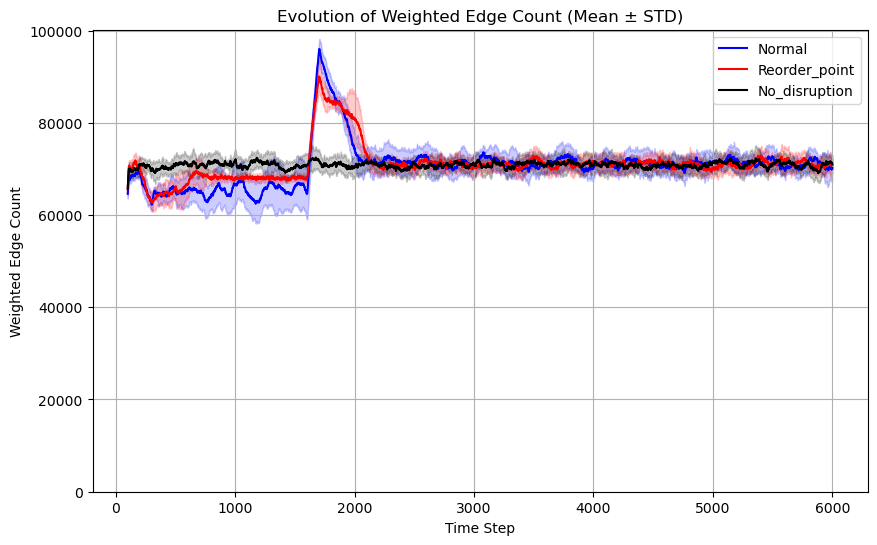

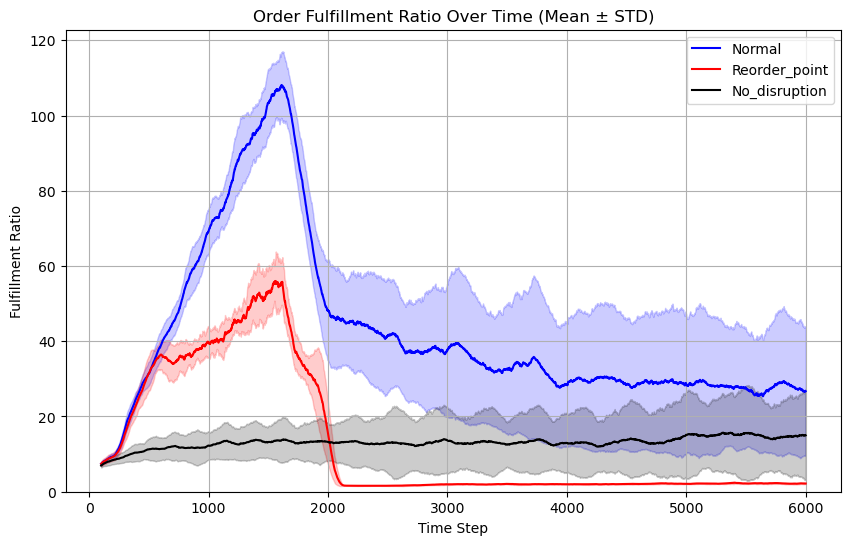

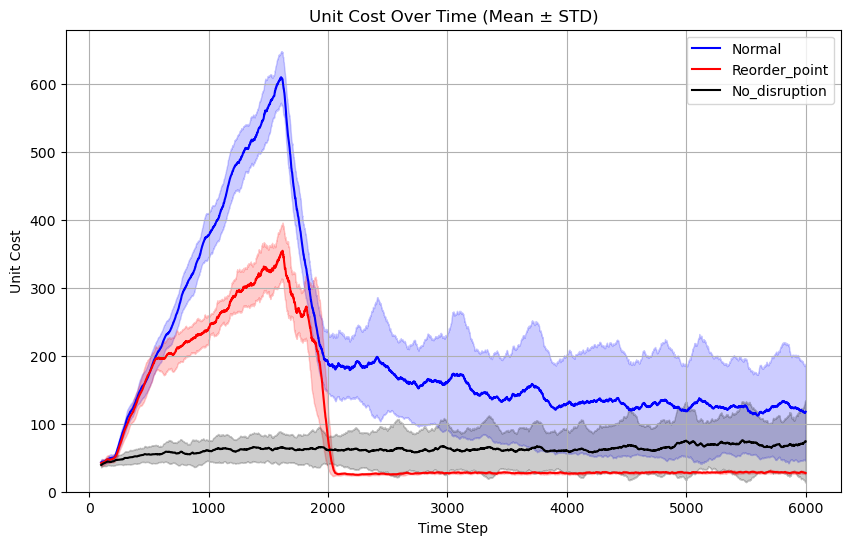

In [21]:
# material capacity change longer
change_schedule_A = {
    200: {"s_material_capacity": 100},
    1600: {"s_material_capacity": 200}
}

change_schedule_C = {
    200: {"s_material_capacity": 100},
    500: {"rm_procurement_mode": "reorder_point"},
    1600: {"s_material_capacity": 200}
}



change_schedule_F = {
}
total_steps = 6000
def run_scenario(scenario_name, change_schedule):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="heterogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
        logistics_speed=1000.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=6000,
        num_reps=10,
        change_schedule=change_schedule,
        return_model=False,           
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }
# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)

results_C = run_scenario("Strategy C", change_schedule_C)

results_F = run_scenario("Strategy F", change_schedule_F)
time_steps = np.arange(1, total_steps + 1)
start = 100                      # 想裁掉前多少步
x = time_steps[start:]  

edge_dict = {
    "Normal"                     : ("blue"  , results_A),

    "Reorder_point"              : ("red"   , results_C),

    "No_disruption"              : ("black"  , results_F),
}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

Running scenario: Strategy A
Running scenario: Strategy B
Running scenario: Strategy C
Running scenario: Strategy D
Running scenario: Strategy E
Running scenario: Strategy F


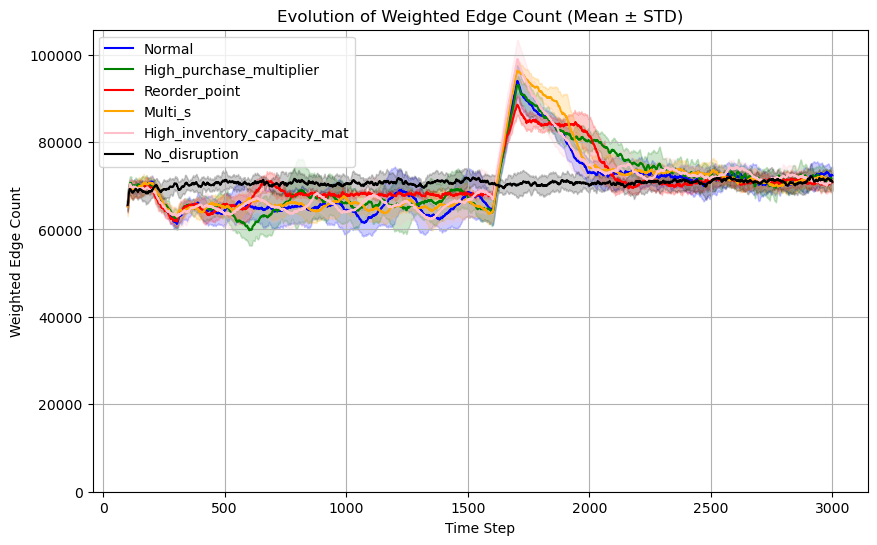

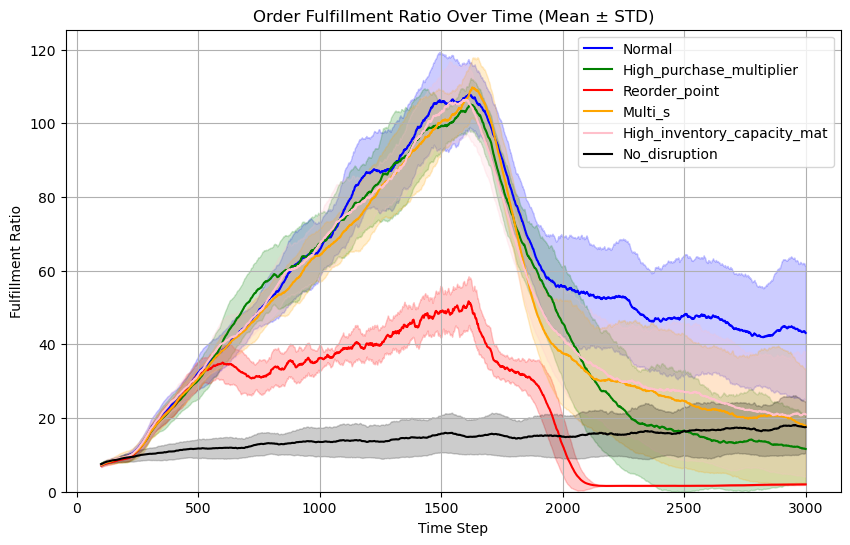

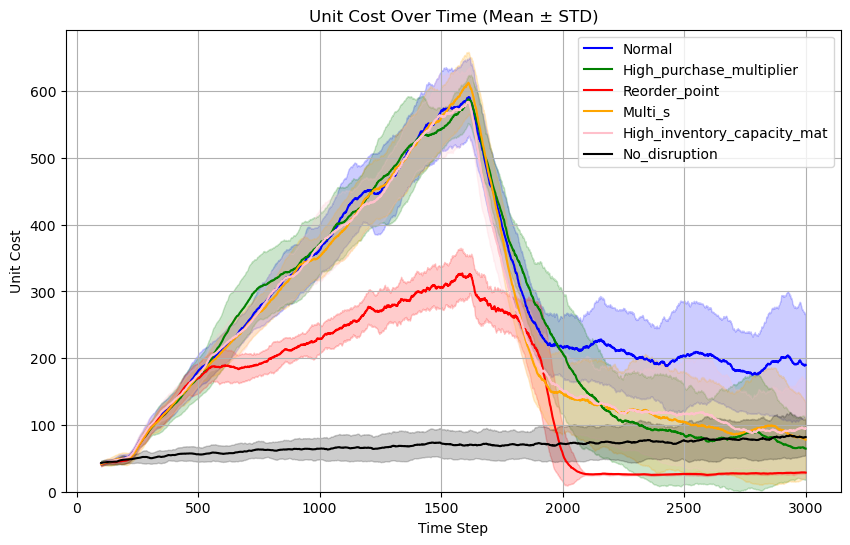

In [20]:
# material capacity change
change_schedule_A = {
    200: {"s_material_capacity": 100},
    1600: {"s_material_capacity": 200}
}
change_schedule_B = {
    200: {"s_material_capacity": 100},
    500: {"rm_purchase_multiplier": 2},
    1600: {"s_material_capacity": 200}
}
change_schedule_C = {
    200: {"s_material_capacity": 100},
    500: {"rm_procurement_mode": "reorder_point"},
    1600: {"s_material_capacity": 200}
}
change_schedule_D = {
    200: {"s_material_capacity": 100},
    500: {"material_order_mode":"multi_s"},
    1600: {"s_material_capacity": 200}
}
change_schedule_E = {
    200: {"s_material_capacity": 100},
    500: {"m_inventory_capacity_material":2000},
    1600: {"s_material_capacity": 200}
}

change_schedule_F = {
}
total_steps = 3000
def run_scenario(scenario_name, change_schedule):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="heterogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
        logistics_speed=1000.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=3000,
        num_reps=10,
        change_schedule=change_schedule,
        return_model=False,           
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }
# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)
results_E = run_scenario("Strategy E", change_schedule_E)
results_F = run_scenario("Strategy F", change_schedule_F)
time_steps = np.arange(1, total_steps + 1)
start = 100                      # 想裁掉前多少步
x = time_steps[start:]  

edge_dict = {
    "Normal"                     : ("blue"  , results_A),
    "High_purchase_multiplier"   : ("green" , results_B),
    "Reorder_point"              : ("red"   , results_C),
    "Multi_s"                    : ("orange", results_D),
    "High_inventory_capacity_mat" : ("pink" , results_E),
    "No_disruption"              : ("black"  , results_F),
}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

Running scenario: Strategy A
Running scenario: Strategy B
Running scenario: Strategy C
Running scenario: Strategy D
Running scenario: Strategy E


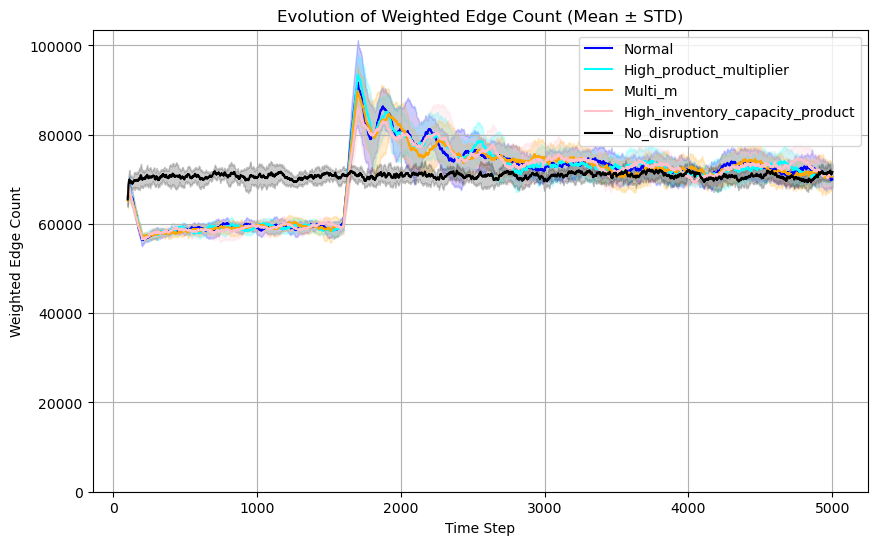

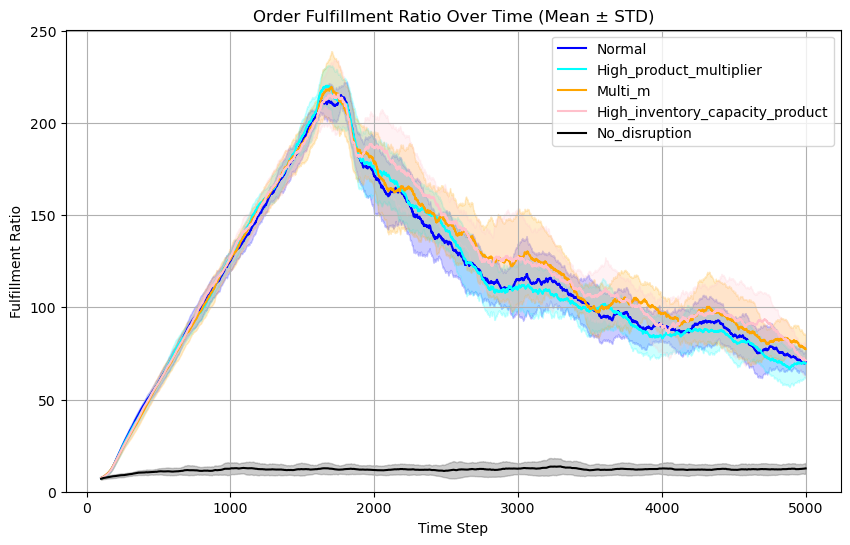

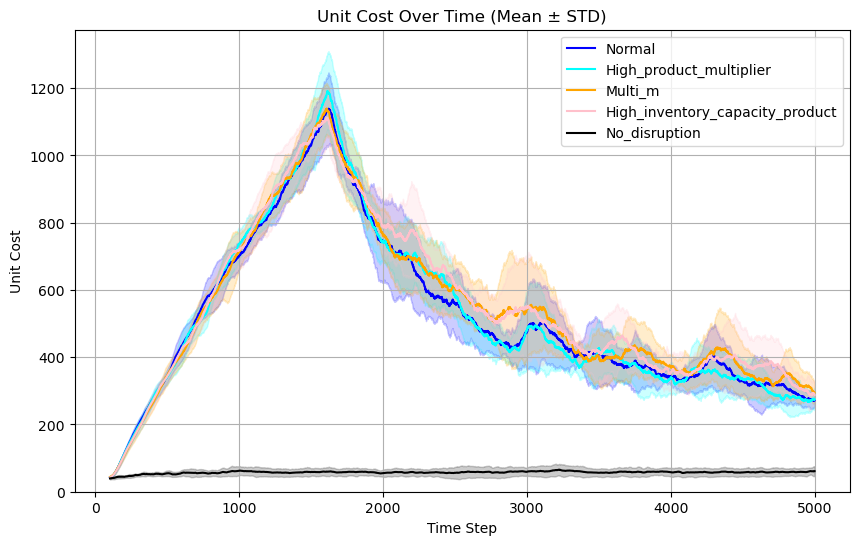

In [8]:
#product capacity change
def run_scenario(scenario_name, change_schedule):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="heterogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
        logistics_speed=1000.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=5000,
        num_reps=10,
        change_schedule=change_schedule,
        return_model=False,           
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }


change_schedule_A = {
    100: {"m_production_capacity": 115},
    1600: {"m_production_capacity": 230}
    
}
change_schedule_B = {
    100: {"m_production_capacity": 115},
    500: {"rm_produce_multiplier": 2},
    1600: {"m_production_capacity": 230}
}
change_schedule_C = {
    100: {"m_production_capacity": 115},
    500: {"product_order_mode":"multi_m"},
    1600: {"m_production_capacity": 230}
}
change_schedule_D = {
    100: {"m_production_capacity": 115},
    500: {"m_inventory_capacity_product":1400},
    1600: {"m_production_capacity": 230}
}
change_schedule_E = {
}

total_steps = 5000

# 分别运行 3 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)
results_E = run_scenario("Strategy E", change_schedule_E)
time_steps = np.arange(1, total_steps + 1)
start = 100                      # 想裁掉前多少步
x = time_steps[start:]  

edge_dict = {
    "Normal"                     : ("blue"  , results_A),
    "High_product_multiplier"   : ("cyan" , results_B),
    "Multi_m"              : ("orange"   , results_C),
    "High_inventory_capacity_product"                    : ("pink", results_D),
    "No_disruption"              : ("black"  , results_E),
}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

Running scenario: Strategy A
Running scenario: Strategy B
Running scenario: Strategy C
Running scenario: Strategy D
Running scenario: Strategy E


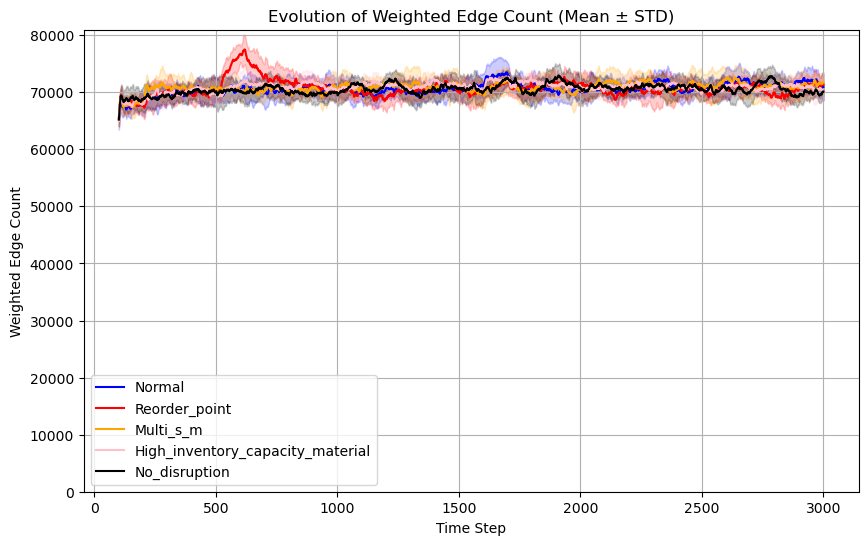

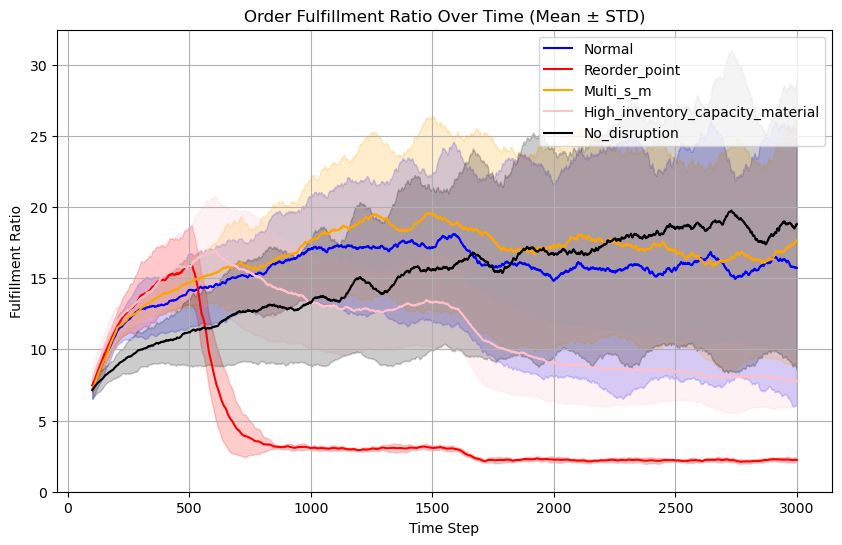

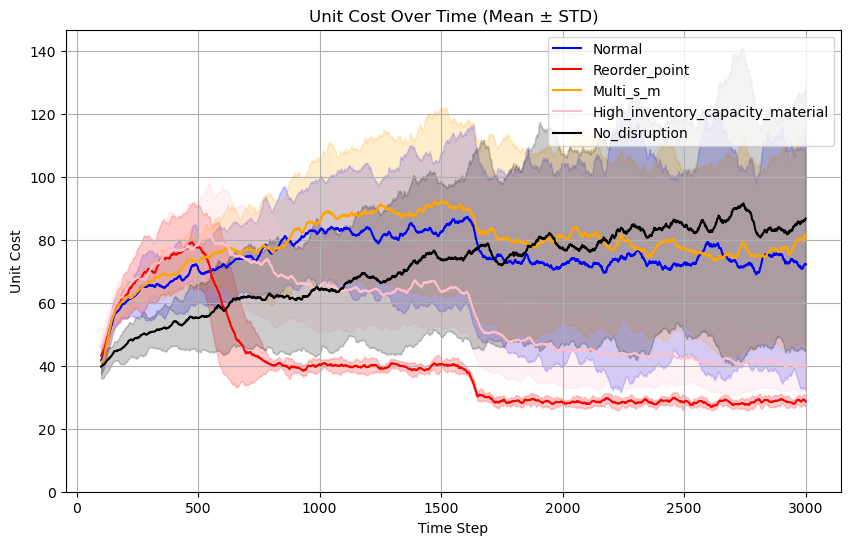

In [13]:
#logistics frozen
def run_scenario(scenario_name, change_schedule):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="heterogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
        logistics_speed=1000.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=3000,
        num_reps=10,
        change_schedule=change_schedule,
        return_model=False,         
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }
change_schedule_A = {
    100: {"logistics_speed": 500},
    1600: {"logistics_speed": 1000}
}
change_schedule_B = {
    100: {"logistics_speed": 500},
    500: {"rm_procurement_mode":"reorder_point"},
    1600: {"logistics_speed": 1000}
}
change_schedule_C = {
    100: {"logistics_speed": 500},
    500: {
        "maerial_order_mode": "multi_s",
        "product_order_mode":"multi_m"
    },
    1600: {"logistics_speed": 1000}
}
change_schedule_D = {
    100: {"logistics_speed": 500},
    500: {"m_inventory_capacity_material":2000},
    1600: {"logistics_speed": 1000}
}
change_schedule_E = {
}
total_steps = 3000

# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)
results_E = run_scenario("Strategy E", change_schedule_E)

time_steps = np.arange(1, total_steps + 1)
start = 100                      # 想裁掉前多少步
x = time_steps[start:]  

edge_dict = {
    "Normal"                     : ("blue"  , results_A),
    "Reorder_point"   : ("red" , results_B),
    "Multi_s_m"              : ("orange"   , results_C),
    "High_inventory_capacity_material"                    : ("pink", results_D),
    "No_disruption"              : ("black"  , results_E),
}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

Running scenario: Strategy A
Running scenario: Strategy B
Running scenario: Strategy C
Running scenario: Strategy D
Running scenario: Strategy E


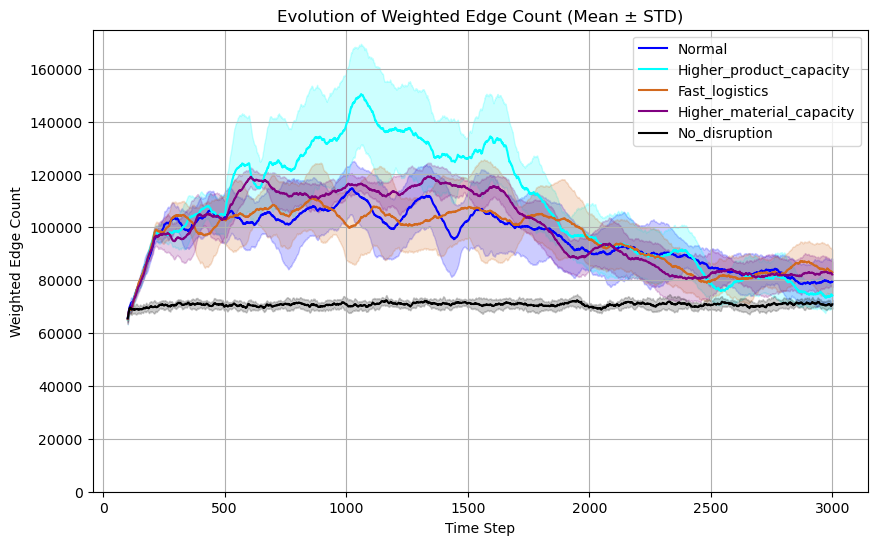

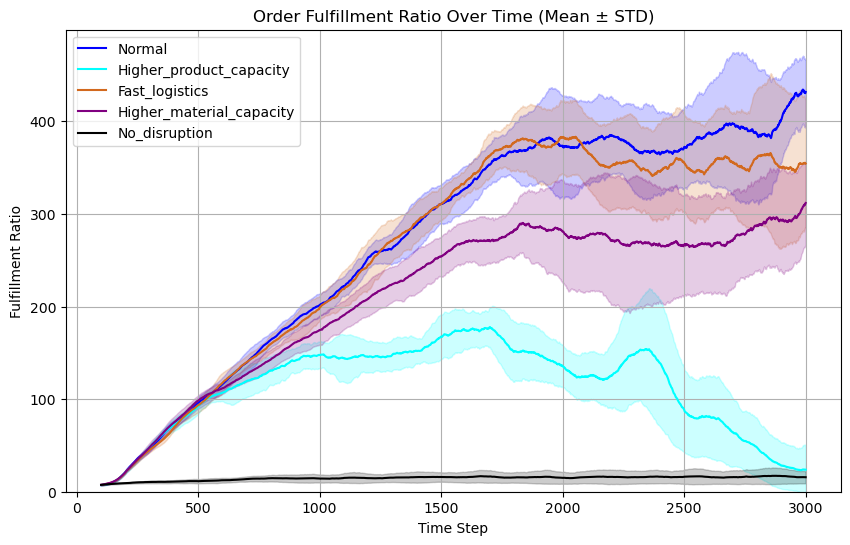

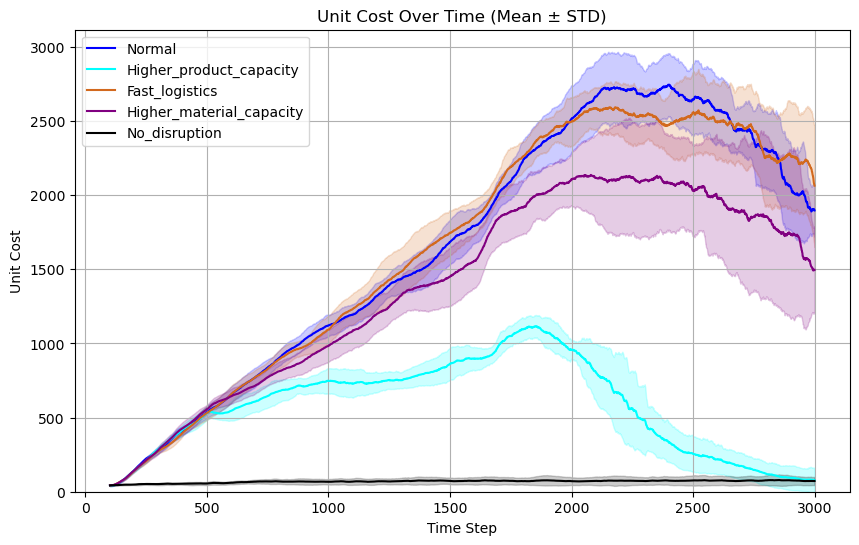

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [14]:
#demand increase
def run_scenario(scenario_name, change_schedule):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="heterogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
        logistics_speed=1000.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=3000,
        num_reps=10,
        change_schedule=change_schedule,
        return_model=False,     
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }
change_schedule_A = {
    100: {"cust_demand_multiplier": 2},
    1600:{"cust_demand_multiplier": 1}
}
change_schedule_B = {
    100: {"cust_demand_multiplier": 2},
    500: {"m_production_capacity": 460},
    1600:{"cust_demand_multiplier": 1}
}
change_schedule_C = {
    100: {"cust_demand_multiplier": 2},
    500: {"logistics_speed":2000},
    1600:{"cust_demand_multiplier": 1}
}
change_schedule_D = {
    100: {"cust_demand_multiplier": 2},
    500: {"s_material_capacity":400},
    1600:{"cust_demand_multiplier": 1}
}
change_schedule_E = {
}

total_steps = 3000

# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)
results_E = run_scenario("Strategy E", change_schedule_E)
time_steps = np.arange(1, total_steps + 1)
start = 100                      # 想裁掉前多少步
x = time_steps[start:]  

edge_dict = {
    "Normal"                     : ("blue"  , results_A),
    "Higher_product_capacity"   : ("cyan" , results_B),
    "Fast_logistics"              : ("chocolate"   , results_C),
    "Higher_material_capacity"                    : ("purple", results_D),
    "No_disruption"              : ("black"  , results_E),
}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(10, 6))

Running scenario: Strategy A
Running scenario: Strategy B
Running scenario: Strategy C
Running scenario: Strategy D
Running scenario: Strategy E
Running scenario: Strategy F
Running scenario: Strategy G


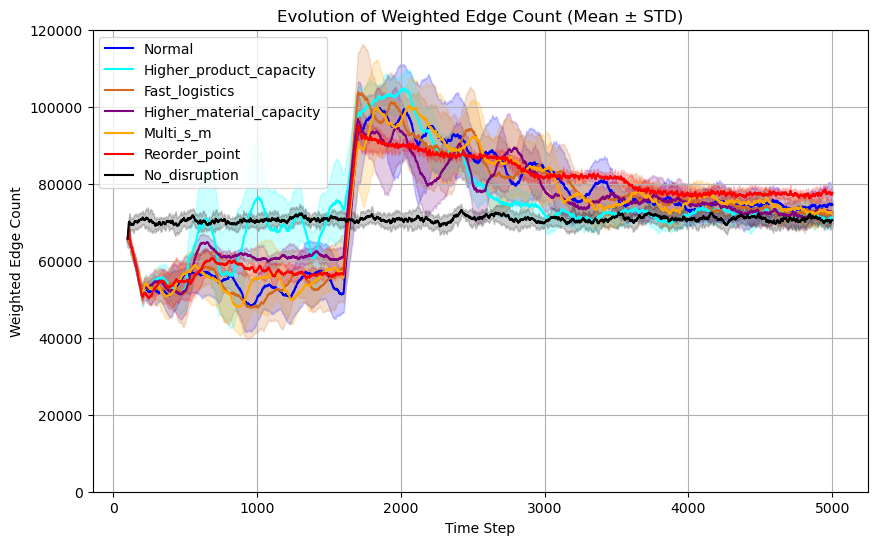

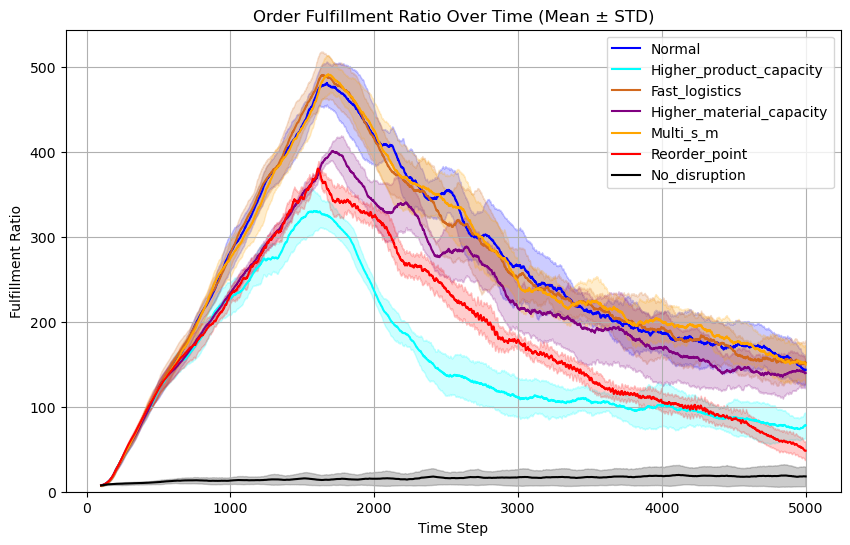

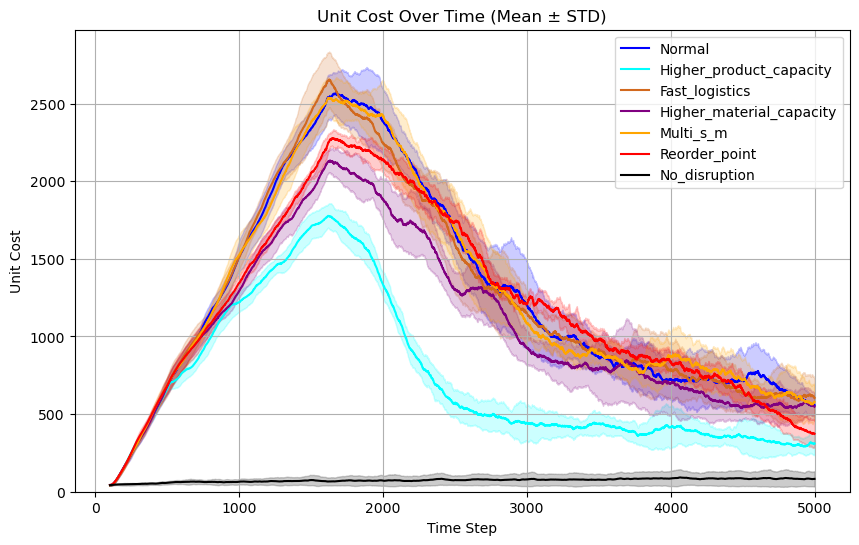

In [20]:
#climate
def run_scenario(scenario_name, change_schedule, total_steps=5000, num_reps=10):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="heterogeneous",
        logistics_speed=1000,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=5000,   # ✅ 动态传入
        num_reps=10,         # ✅ 动态传入
        change_schedule=change_schedule,
        return_model=False,
        num_customers=36,
        num_manufacturers=6,
        num_suppliers=14
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results


    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }
change_schedule_A = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}
change_schedule_B = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"m_production_capacity": 230},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}
change_schedule_C = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"logistics_speed":1000},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}
change_schedule_D = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"s_material_capacity":200},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}
change_schedule_E = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"maerial_order_mode": "multi_s", "product_order_mode":"multi_m"},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}
change_schedule_F = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"rm_procurement_mode":"reorder_point"},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}
change_schedule_G = {
}
total_steps = 5000
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)
results_E = run_scenario("Strategy E", change_schedule_E)
results_F = run_scenario("Strategy F", change_schedule_F)
results_G = run_scenario("Strategy G", change_schedule_G)
time_steps = np.arange(1, total_steps + 1)
start = 100                       # 想裁掉前多少步
x = time_steps[start:]  

edge_dict = {
    "Normal"                     : ("blue"  , results_A),
    "Higher_product_capacity"   : ("cyan" , results_B),
    
    "Fast_logistics"              : ("chocolate"   , results_C),
    "Higher_material_capacity"                    : ("purple", results_D),
    "Multi_s_m" : ("orange" , results_E),
    "Reorder_point"              : ("red"  , results_F),
    "No_disruption"              : ("black"  , results_G),
}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

Running scenario: Strategy A
Running scenario: Strategy B
Running scenario: Strategy C
Running scenario: Strategy D
Running scenario: Strategy E
Running scenario: Strategy F
Running scenario: Strategy G


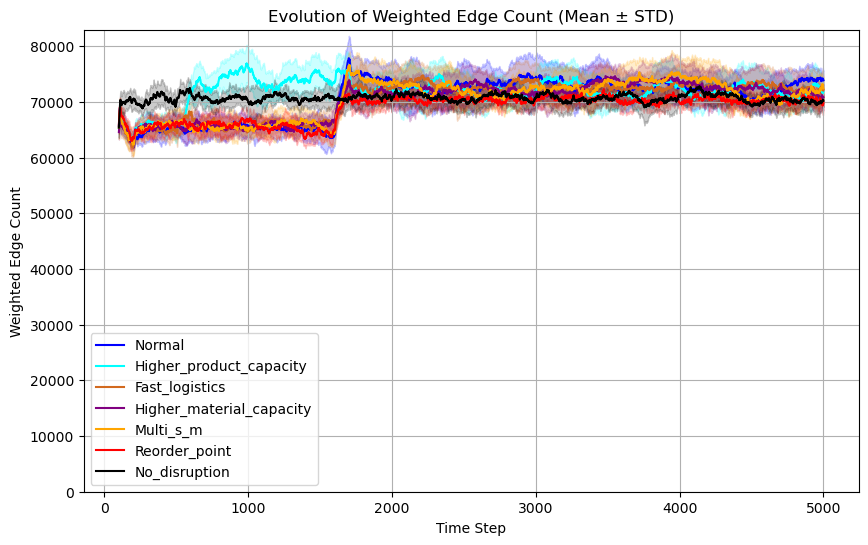

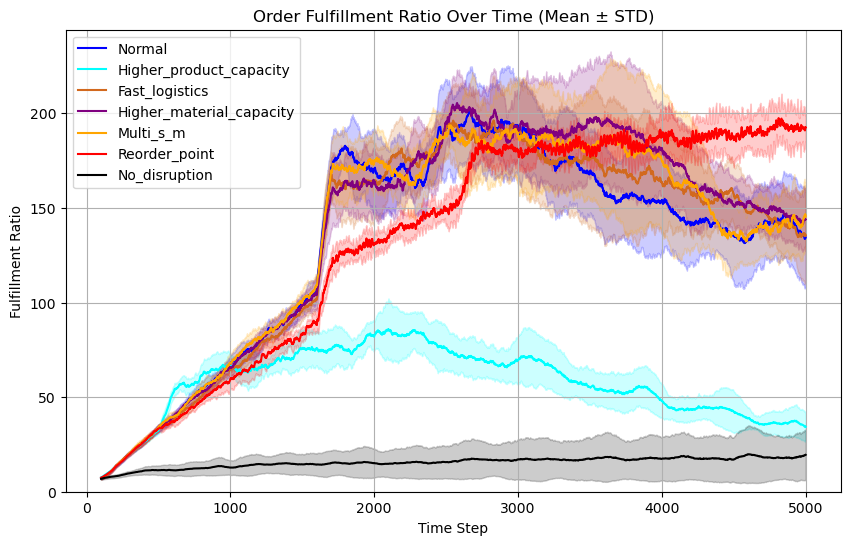

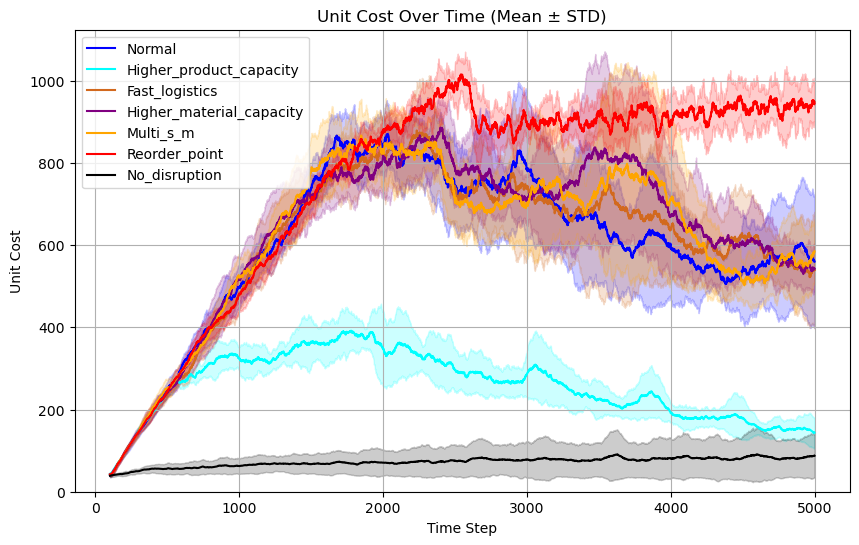

In [9]:
#climate (regional)
def run_scenario(scenario_name, change_schedule, total_steps=5000, num_reps=10):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="regional_heterogeneous",
        logistics_speed=1000,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=5000,   # ✅ 动态传入
        num_reps=10,         # ✅ 动态传入
        change_schedule=change_schedule,
        return_model=False,
        num_customers=36,
        num_manufacturers=6,
        num_suppliers=14
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results


    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }
change_schedule_A = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}
change_schedule_B = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"m_production_capacity": 230},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}
change_schedule_C = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"logistics_speed":1000},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}
change_schedule_D = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"s_material_capacity":200},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}
change_schedule_E = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"maerial_order_mode": "multi_s", "product_order_mode":"multi_m"},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}
change_schedule_F = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"rm_procurement_mode":"reorder_point"},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}
change_schedule_G = {
}
total_steps = 5000
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)
results_E = run_scenario("Strategy E", change_schedule_E)
results_F = run_scenario("Strategy F", change_schedule_F)
results_G = run_scenario("Strategy G", change_schedule_G)
time_steps = np.arange(1, total_steps + 1)
start = 100                       # 想裁掉前多少步
x = time_steps[start:]  

edge_dict = {
    "Normal"                     : ("blue"  , results_A),
    "Higher_product_capacity"   : ("cyan" , results_B),
    "Fast_logistics"              : ("chocolate"   , results_C),
    "Higher_material_capacity"                    : ("purple", results_D),
    "Multi_s_m" : ("orange" , results_E),
    "Reorder_point"              : ("red"  , results_F),
    "No_disruption"              : ("black"  , results_G),
}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

Running scenario: Strategy F


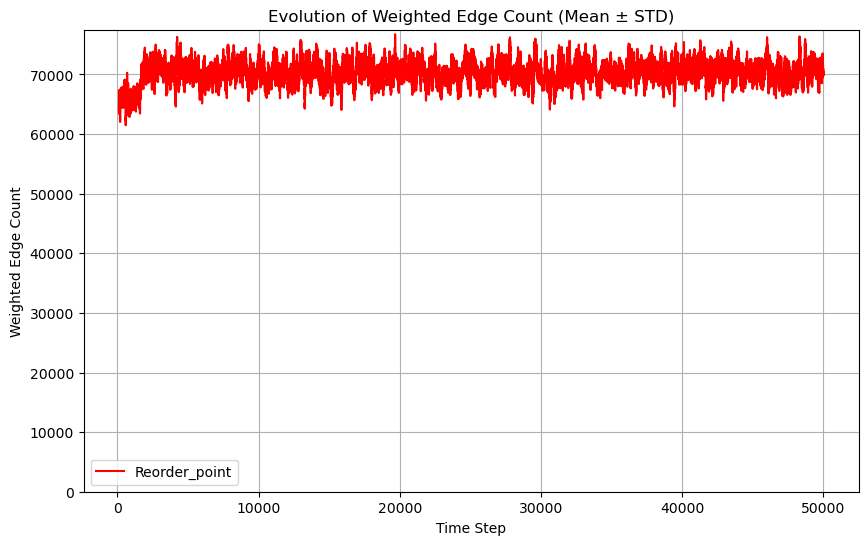

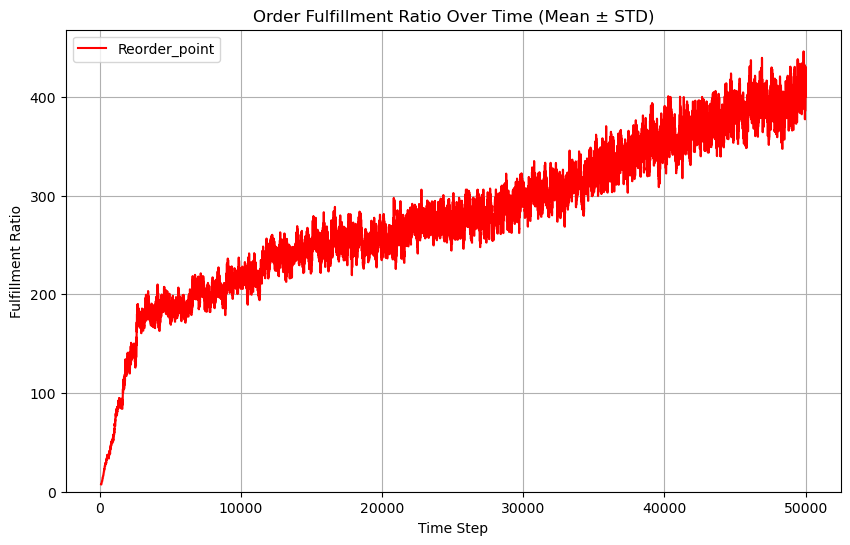

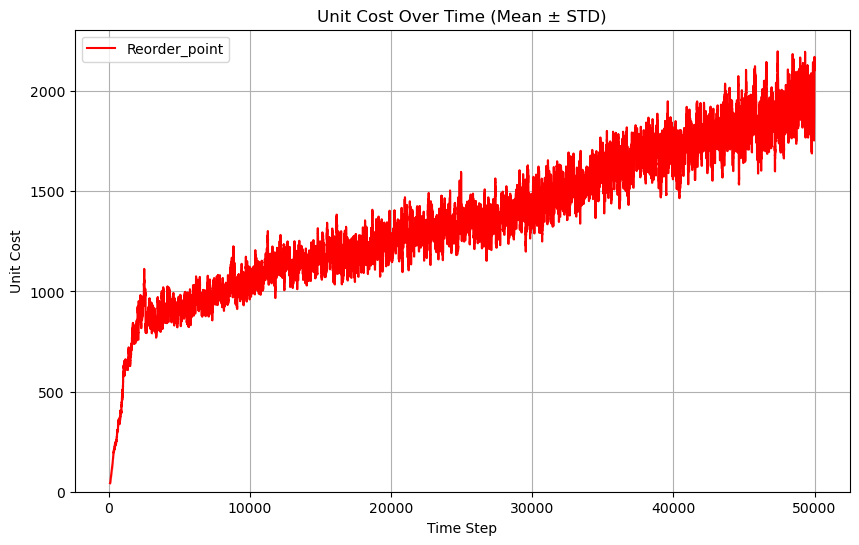

In [12]:
#climate (regional)
def run_scenario(scenario_name, change_schedule, total_steps=50000, num_reps=1):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="regional_heterogeneous",
        logistics_speed=1000,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=50000,   # ✅ 动态传入
        num_reps=1,         # ✅ 动态传入
        change_schedule=change_schedule,
        return_model=False,
        num_customers=36,
        num_manufacturers=6,
        num_suppliers=14
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results


    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }

change_schedule_F = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"rm_procurement_mode":"reorder_point"},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}

total_steps = 50000

results_F = run_scenario("Strategy F", change_schedule_F)

time_steps = np.arange(1, total_steps + 1)
start = 100                       # 想裁掉前多少步
x = time_steps[start:]  

edge_dict = {

    "Reorder_point"              : ("red"  , results_F),

}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

Running scenario: Strategy F


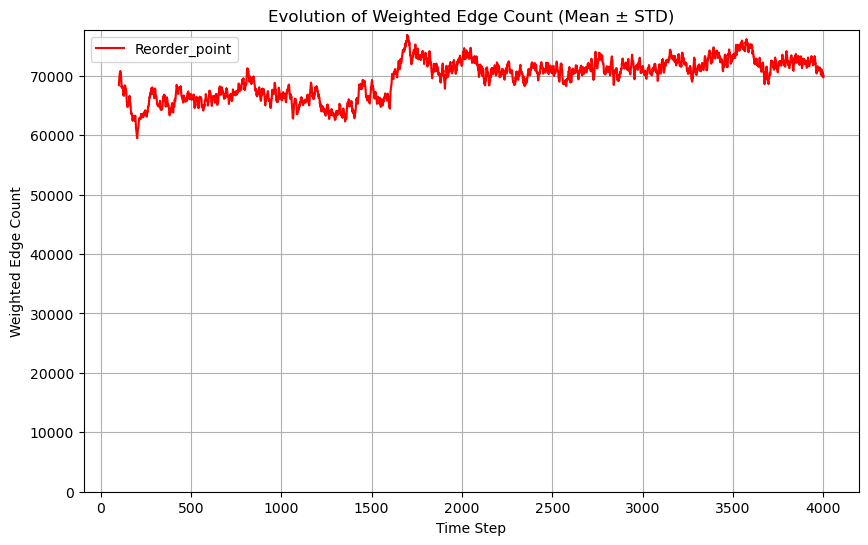

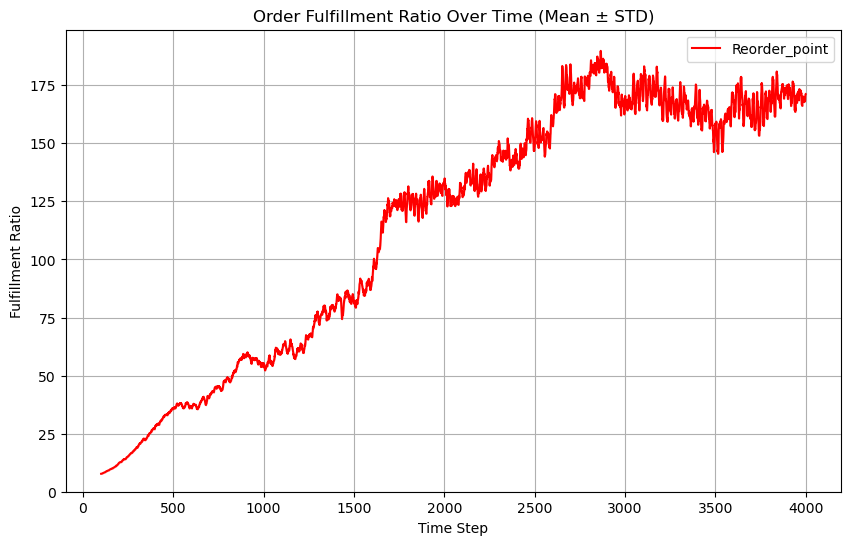

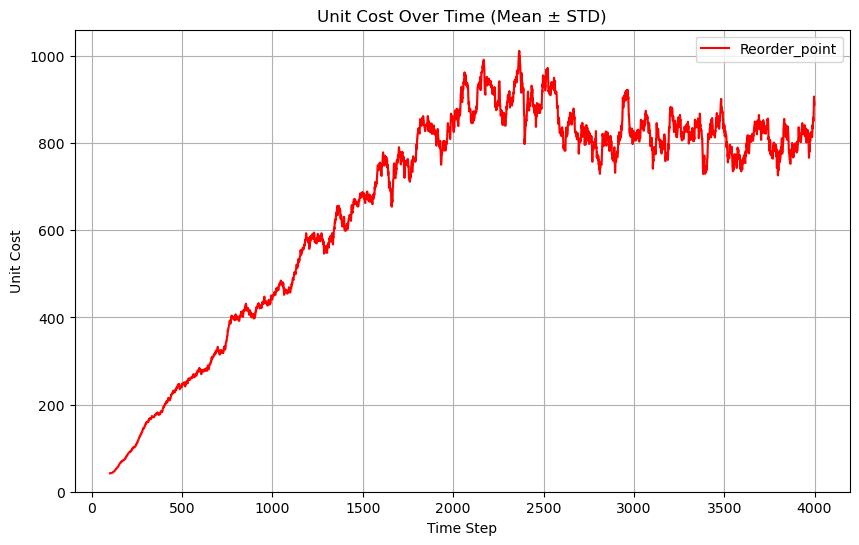

In [12]:
#climate (regional)
def run_scenario(scenario_name, change_schedule, total_steps=4000, num_reps=1):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="regional_heterogeneous",
        logistics_speed=1000,
        rm_procurement_mode="gap_based",
        rm_reorder_point=700,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=4000,   # ✅ 动态传入
        num_reps=1,         # ✅ 动态传入
        change_schedule=change_schedule,
        return_model=False,
        num_customers=36,
        num_manufacturers=6,
        num_suppliers=14
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results


    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }

change_schedule_F = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"rm_procurement_mode":"reorder_point"},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}

total_steps = 4000

results_F = run_scenario("Strategy F", change_schedule_F)

time_steps = np.arange(1, total_steps + 1)
start = 100                       # 想裁掉前多少步
x = time_steps[start:]  

edge_dict = {

    "Reorder_point"              : ("red"  , results_F),

}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

Running scenario: Strategy F
Running scenario: Strategy G
Running scenario: Strategy H
Running scenario: Strategy I


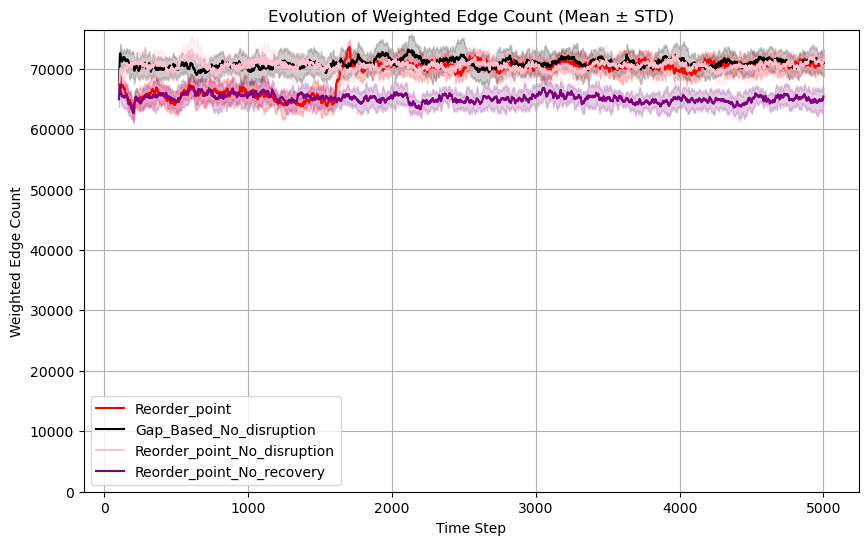

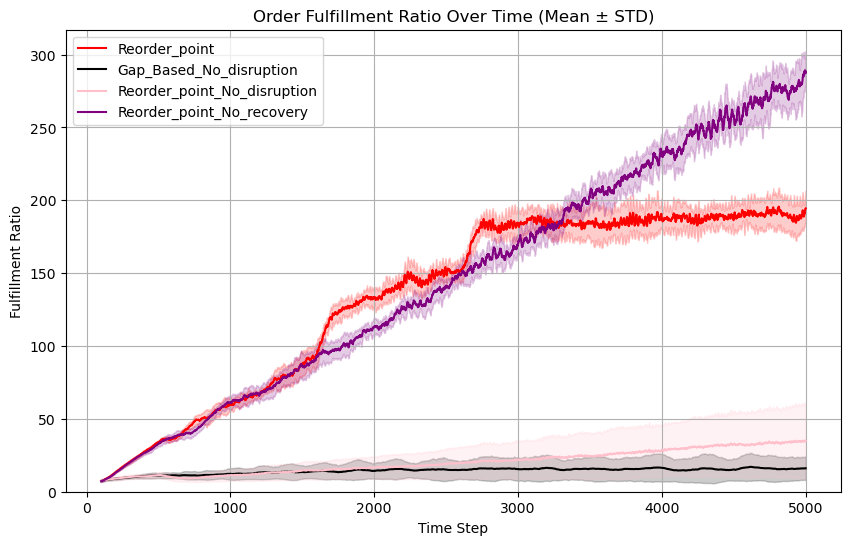

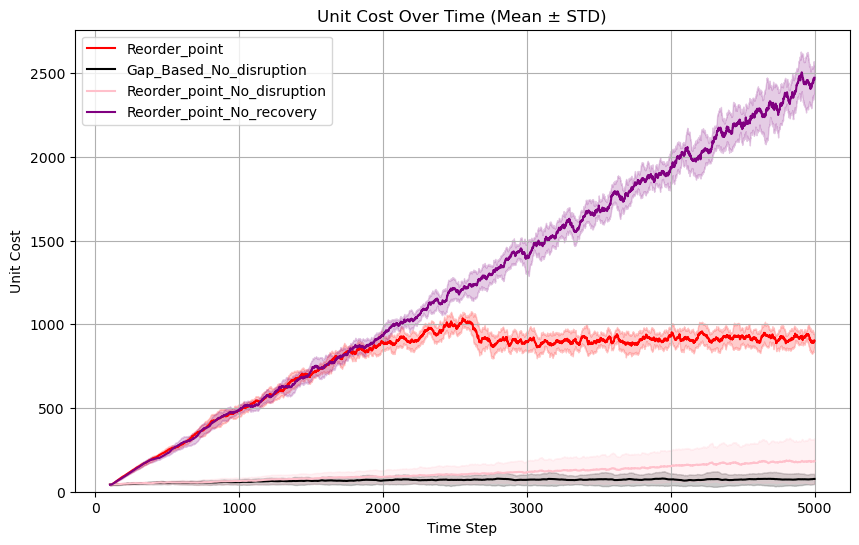

In [8]:
#climate (regional)
def run_scenario(scenario_name, change_schedule, total_steps=5000, num_reps=10):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="regional_heterogeneous",
        logistics_speed=1000,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=5000,   # ✅ 动态传入
        num_reps=10,         # ✅ 动态传入
        change_schedule=change_schedule,
        return_model=False,
        num_customers=36,
        num_manufacturers=6,
        num_suppliers=14
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results


    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }

change_schedule_F = {
    100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"rm_procurement_mode":"reorder_point"},
    1600:{"s_material_capacity":200, "m_production_capacity":230, "logistics_speed":1000, "cust_demand_multiplier": 1}
}
change_schedule_G = {
}
change_schedule_H = {
    
    500: {"rm_procurement_mode":"reorder_point"}
}
change_schedule_I = {100: {"s_material_capacity":100, "m_production_capacity":115, "logistics_speed":500, "cust_demand_multiplier": 1.2},
    500: {"rm_procurement_mode":"reorder_point"}
}
total_steps = 5000

results_F = run_scenario("Strategy F", change_schedule_F)
results_G = run_scenario("Strategy G", change_schedule_G)
results_H = run_scenario("Strategy H", change_schedule_H)
results_I= run_scenario("Strategy I", change_schedule_I)
time_steps = np.arange(1, total_steps + 1)
start = 100                       # 想裁掉前多少步
x = time_steps[start:]  

edge_dict = {

    "Reorder_point"              : ("red"  , results_F),
    "Gap_Based_No_disruption"              : ("black"  , results_G),
    "Reorder_point_No_disruption"              : ("pink"  , results_H),
    "Reorder_point_No_recovery"              : ("Purple"  , results_I),

}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

Running scenario: Strategy A
Running scenario: Strategy B
Running scenario: Strategy C
Running scenario: Strategy D
Running scenario: Strategy E
Running scenario: Strategy F
Running scenario: Strategy G


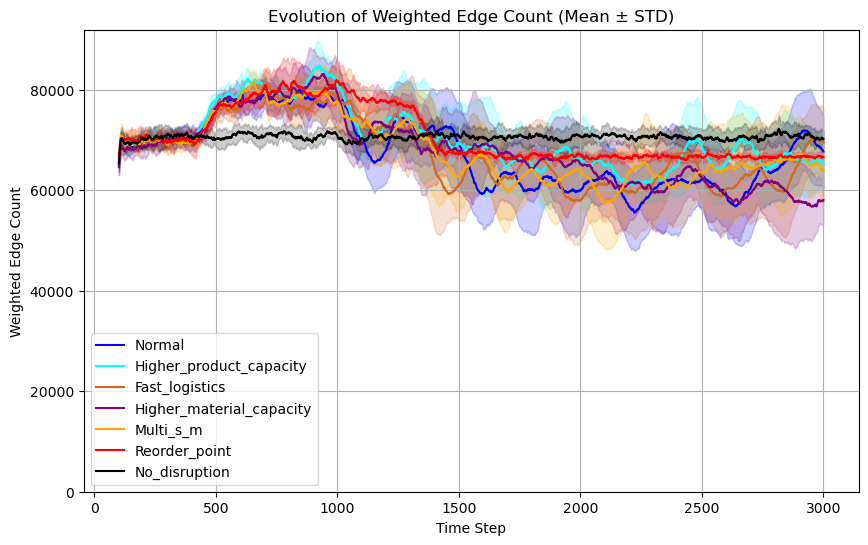

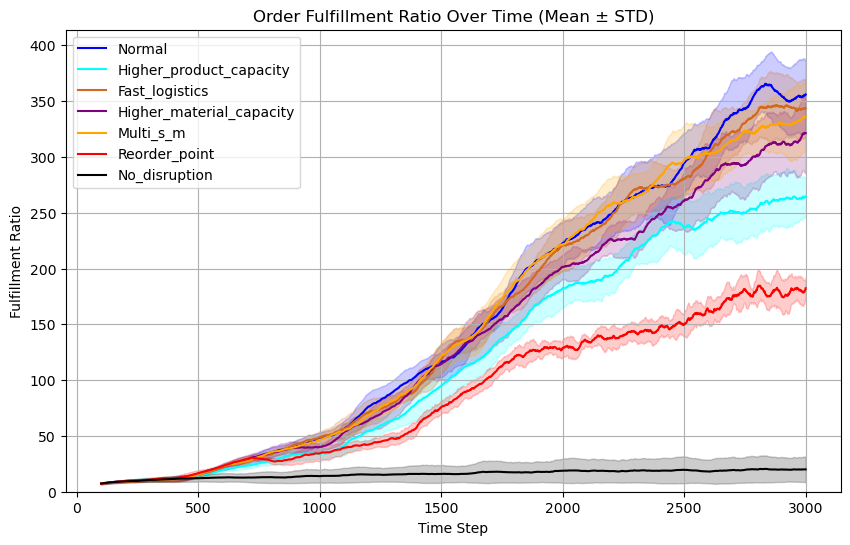

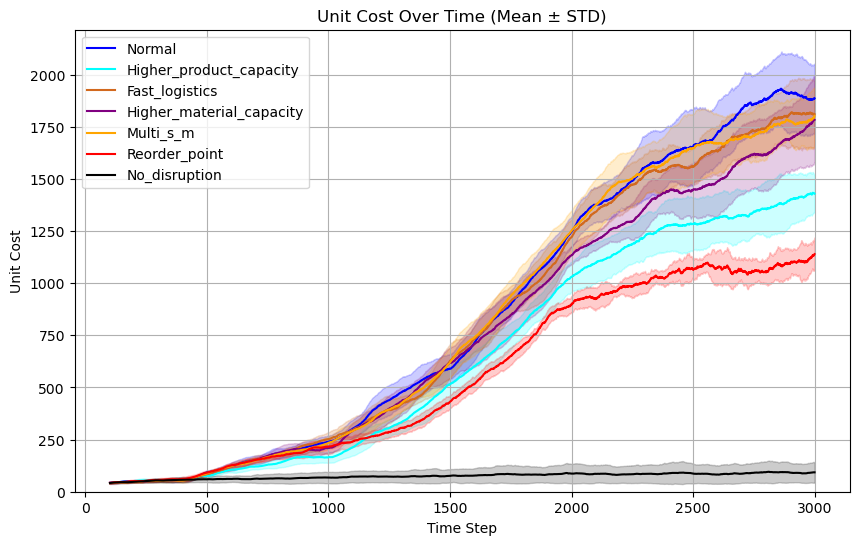

In [21]:
#climate gradually global
def run_scenario(scenario_name, change_schedule, total_steps=3000, num_reps=10):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="heterogeneous",
        logistics_speed=1000,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=3000,   # ✅ 动态传入
        num_reps=10,         # ✅ 动态传入
        change_schedule=change_schedule,
        return_model=False,
        num_customers=36,
        num_manufacturers=6,
        num_suppliers=14     
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }
change_schedule_A = {
    100: {"s_material_capacity":180},
    400: {"s_material_capacity":160, "m_production_capacity":207, "cust_demand_multiplier": 1.2},
    700: {"s_material_capacity":140},
    1000: {"s_material_capacity":120, "m_production_capacity":184},
    1300: {"s_material_capacity":100},
    1600: {"m_production_capacity":161},
    1800:{"cust_demand_multiplier": 1}
}
change_schedule_B = {
    100: {"s_material_capacity":180},
    400: {"s_material_capacity":160,"cust_demand_multiplier": 1.2},
    700: {"s_material_capacity":140},
    1000: {"s_material_capacity":120},
    1300: {"s_material_capacity":100},
    1800:{"cust_demand_multiplier": 1}
}
change_schedule_C = {
    100: {"s_material_capacity":180},
    400: {"s_material_capacity":160, "m_production_capacity":207, "cust_demand_multiplier": 1.2},
    700: {"logistics_speed":2000, "s_material_capacity":140},
    1000: {"s_material_capacity":120, "m_production_capacity":184},
    1300: {"s_material_capacity":100},
    1600: {"m_production_capacity":161},
    1800:{"cust_demand_multiplier": 1}
}
change_schedule_D = {
    100: {"s_material_capacity":180},
    400: {"s_material_capacity":160, "m_production_capacity":207, "cust_demand_multiplier": 1.2},
    700: {"rm_purchase_multiplier":2, "s_material_capacity":140},
    1000: {"s_material_capacity":120, "m_production_capacity":184},
    1300: {"s_material_capacity":100},
    1600: {"m_production_capacity":161},
    1800:{"cust_demand_multiplier": 1}
}
change_schedule_E = {
    100: {"s_material_capacity":180},
    400: {"s_material_capacity":160, "m_production_capacity":207, "cust_demand_multiplier": 1.2},
    700: {"maerial_order_mode": "multi_s", "product_order_mode":"multi_m", "s_material_capacity":140},
    1000: {"s_material_capacity":120, "m_production_capacity":184},
    1300: {"s_material_capacity":100},
    1600: {"m_production_capacity":161},
    1800:{"cust_demand_multiplier": 1}
}
change_schedule_F = {
    100: {"s_material_capacity":180},
    400: {"s_material_capacity":160, "m_production_capacity":207, "cust_demand_multiplier": 1.2},
    700: {"rm_procurement_mode":"reorder_point", "s_material_capacity":120},
    1000: {"s_material_capacity":120, "m_production_capacity":184},
    1300: {"s_material_capacity":100},
    1600: {"m_production_capacity":161},
    1800:{"cust_demand_multiplier": 1}
}
change_schedule_G = {
}

total_steps = 3000

# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)
results_E = run_scenario("Strategy E", change_schedule_E)
results_F = run_scenario("Strategy F", change_schedule_F)
results_G = run_scenario("Strategy G", change_schedule_G)
time_steps = np.arange(1, total_steps + 1)
start = 100                       # 想裁掉前多少步
x = time_steps[start:]  

edge_dict = {
    "Normal"                     : ("blue"  , results_A),
    "Higher_product_capacity"   : ("cyan" , results_B),
    "Fast_logistics"              : ("chocolate"   , results_C),
    "Higher_material_capacity"                    : ("purple", results_D),
    "Multi_s_m" : ("orange" , results_E),
    "Reorder_point"              : ("red"  , results_F),
    "No_disruption"              : ("black"  , results_G),
}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

Running scenario: Strategy A
Running scenario: Strategy B
Running scenario: Strategy C
Running scenario: Strategy D
Running scenario: Strategy E
Running scenario: Strategy F
Running scenario: Strategy G


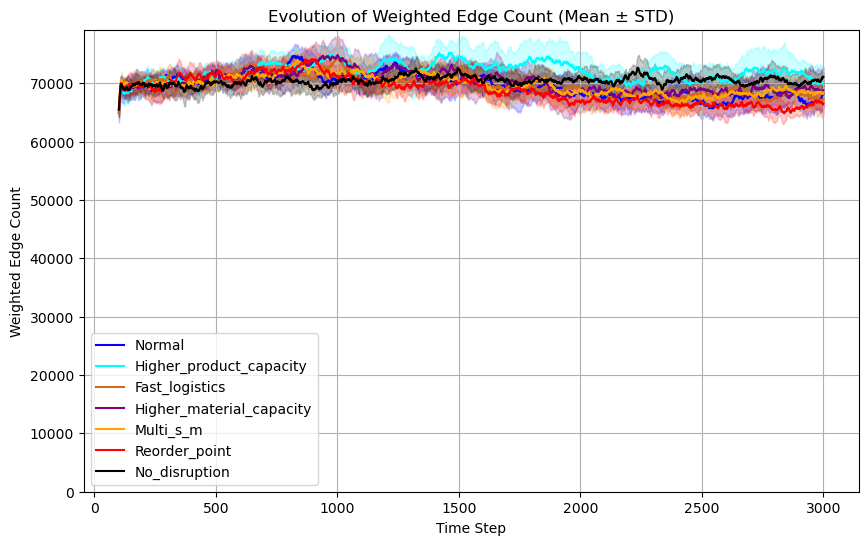

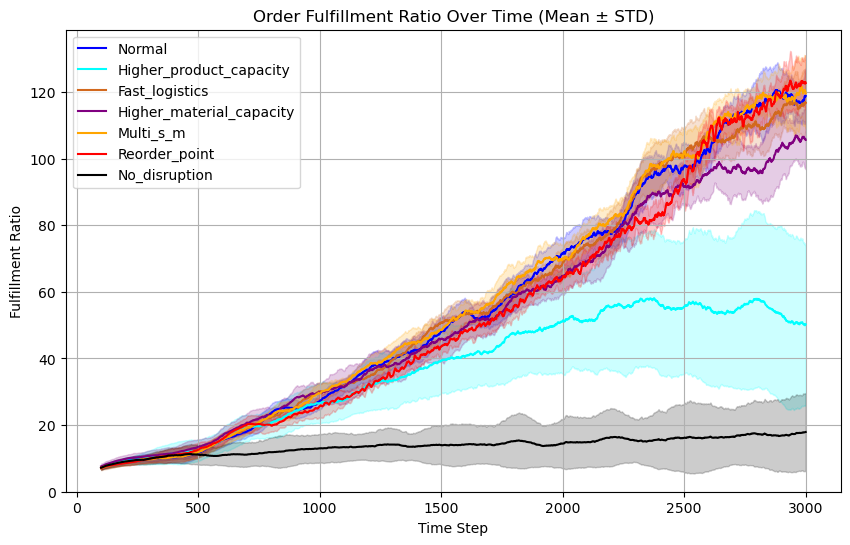

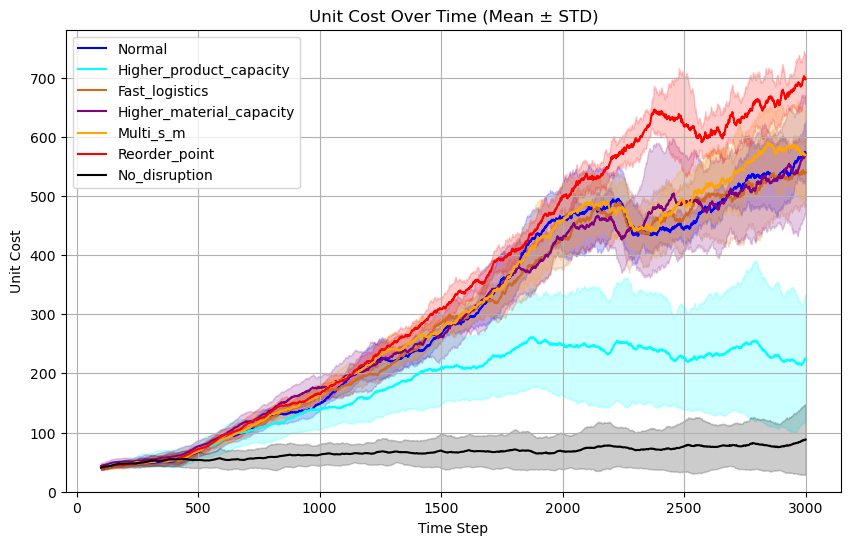

In [22]:
#climate gradually
def run_scenario(scenario_name, change_schedule, total_steps=3000, num_reps=10):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,
        agent_mode="regional_heterogeneous",
        logistics_speed=1000,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=3000,   # ✅ 动态传入
        num_reps=10,         # ✅ 动态传入
        change_schedule=change_schedule,
        return_model=False,
        num_customers=36,
        num_manufacturers=6,
        num_suppliers=14
    )
    (

        mean_edge_series,
        std_edge_series,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

    return {
        "mean_edge_series":  mean_edge_series,
        "std_edge_series":   std_edge_series,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series":  std_ratio_series,
        "mean_uc_series":    mean_uc_series,
        "std_uc_series":     std_uc_series
    }
change_schedule_A = {
    100: {"s_material_capacity":180},
    400: {"s_material_capacity":160, "m_production_capacity":207, "cust_demand_multiplier": 1.2},
    700: {"s_material_capacity":140},
    1000: {"s_material_capacity":120, "m_production_capacity":184},
    1300: {"s_material_capacity":100},
    1600: {"m_production_capacity":161},
    1800:{"cust_demand_multiplier": 1}
}
change_schedule_B = {
    100: {"s_material_capacity":180},
    400: {"s_material_capacity":160,"cust_demand_multiplier": 1.2},
    700: {"s_material_capacity":140},
    1000: {"s_material_capacity":120},
    1300: {"s_material_capacity":100},
    1800:{"cust_demand_multiplier": 1}
}
change_schedule_C = {
    100: {"s_material_capacity":180},
    400: {"s_material_capacity":160, "m_production_capacity":207, "cust_demand_multiplier": 1.2},
    700: {"logistics_speed":2000, "s_material_capacity":140},
    1000: {"s_material_capacity":120, "m_production_capacity":184},
    1300: {"s_material_capacity":100},
    1600: {"m_production_capacity":161},
    1800:{"cust_demand_multiplier": 1}
}
change_schedule_D = {
    100: {"s_material_capacity":180},
    400: {"s_material_capacity":160, "m_production_capacity":207, "cust_demand_multiplier": 1.2},
    700: {"rm_purchase_multiplier":2, "s_material_capacity":140},
    1000: {"s_material_capacity":120, "m_production_capacity":184},
    1300: {"s_material_capacity":100},
    1600: {"m_production_capacity":161},
    1800:{"cust_demand_multiplier": 1}
}
change_schedule_E = {
    100: {"s_material_capacity":180},
    400: {"s_material_capacity":160, "m_production_capacity":207, "cust_demand_multiplier": 1.2},
    700: {"maerial_order_mode": "multi_s", "product_order_mode":"multi_m", "s_material_capacity":140},
    1000: {"s_material_capacity":120, "m_production_capacity":184},
    1300: {"s_material_capacity":100},
    1600: {"m_production_capacity":161},
    1800:{"cust_demand_multiplier": 1}
}
change_schedule_F = {
    100: {"s_material_capacity":180},
    400: {"s_material_capacity":160, "m_production_capacity":207, "cust_demand_multiplier": 1.2},
    700: {"rm_procurement_mode":"reorder_point", "s_material_capacity":120},
    1000: {"s_material_capacity":120, "m_production_capacity":184},
    1300: {"s_material_capacity":100},
    1600: {"m_production_capacity":161},
    1800:{"cust_demand_multiplier": 1}
}
change_schedule_G = {
}

total_steps = 3000

# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)
results_E = run_scenario("Strategy E", change_schedule_E)
results_F = run_scenario("Strategy F", change_schedule_F)
results_G = run_scenario("Strategy G", change_schedule_G)
time_steps = np.arange(1, total_steps + 1)
start = 100                       # 想裁掉前多少步
x = time_steps[start:]  

edge_dict = {
    "Normal"                     : ("blue"  , results_A),
    "Higher_product_capacity"   : ("cyan" , results_B),
    "Fast_logistics"              : ("chocolate"   , results_C),
    "Higher_material_capacity"                    : ("purple", results_D),
    "Multi_s_m" : ("orange" , results_E),
    "Reorder_point"              : ("red"  , results_F),
    "No_disruption"              : ("black"  , results_G),
}
# ------------------------------------------------------------

# ---------- 1. Weighted-Edge Count ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_edge_series"][start:]
    yerr = res["std_edge_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 2. Fulfillment Ratio ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_ratio_series"][start:]
    yerr = res["std_ratio_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

# ---------- 3. Unit Cost ----------
plt.figure(figsize=(10, 6))
for label, (color, res) in edge_dict.items():
    y    = res["mean_uc_series"][start:]
    yerr = res["std_uc_series"][start:]
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True); plt.legend(); plt.ylim(bottom=0)
plt.show()

Scan s_mat (High Demand): 100%|███████████████████████████████████████████████████████| 17/17 [35:20<00:00, 124.76s/it]


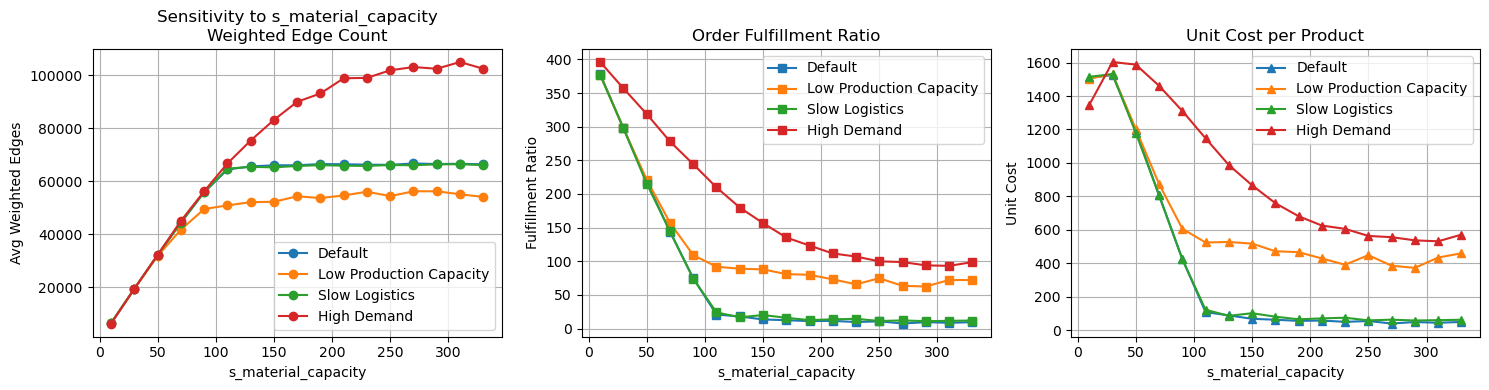

In [6]:
#sensetive for s_mat
from tqdm import tqdm

total_steps = 1000
num_reps    = 5

# 定义三个“静态扰动”场景
scenarios = {
    "Default":       {},
    "Low Production Capacity":{"m_production_capacity": 115},
    "Slow Logistics":{"logistics_speed": 500},
    "High Demand":   {"cust_demand_multiplier": 2.0}
}

# 要扫描的参数范围
s_mat_range  = [10, 30, 50, 70, 90, 110, 130,150,170,190,210,230,250,270,290,310,330]
# 存储结果结构
metrics_smat  = { name: [] for name in scenarios }

def eval_static(base_params, override_params):
    """
    base_params: 场景级别的 override dict
    override_params: 本次扫描时要改动的 dict
    """
    # 1) 全部默认参数
    all_params = dict(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,        # baseline
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,         # baseline
        agent_mode="heterogeneous",
        logistics_speed=1000.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=total_steps,
        num_reps=num_reps,
        change_schedule=None,
        return_model=True,
    )
    # 2) 场景级 override
    all_params.update(base_params)
    # 3) 本次扫描 override
    all_params.update(override_params)

    # 4) 一次性调用，不会再出现同名参数冲突
    _, (mean_edge, std_edge, mean_ratio, std_ratio, mean_uc, std_uc) = run_simulation_with_param_changes(**all_params)
    return np.mean(mean_edge),np.mean(mean_ratio), np.mean(mean_uc)

# —— 扫描 s_material_capacity —— 
for name, base_params in scenarios.items():
    for smc in tqdm(s_mat_range, desc=f"Scan s_mat ({name})"):
        avg_edge, ratio, uc = eval_static(
            base_params,
            {"s_material_capacity": smc}
        )
        metrics_smat[name].append((smc, avg_edge, ratio, uc))


# —— 画图函数 —— 
def plot_three_subplots(metrics, param_label, title_prefix):
    xs = [t[0] for t in next(iter(metrics.values()))]
    fig, axes = plt.subplots(1, 3, figsize=(15,4), sharex=True)

    # 子图1: 加权边数
    ax = axes[0]
    for name,data in metrics.items():
        ax.plot(xs, [t[1] for t in data], marker='o', label=name)
    ax.set(xlabel=param_label, ylabel="Avg Weighted Edges",
           title=title_prefix+"\nWeighted Edge Count")
    ax.grid(); ax.legend()

    # 子图2: 履约率
    ax = axes[1]
    for name,data in metrics.items():
        ax.plot(xs, [t[2] for t in data], marker='s', label=name)
    ax.set(xlabel=param_label, ylabel="Fulfillment Ratio",
           title="Order Fulfillment Ratio")
    ax.grid(); ax.legend()

    # 子图3: 单位成本
    ax = axes[2]
    for name,data in metrics.items():
        ax.plot(xs, [t[3] for t in data], marker='^', label=name)
    ax.set(xlabel=param_label, ylabel="Unit Cost",
           title="Unit Cost per Product")
    ax.grid(); ax.legend()

    plt.tight_layout()
    plt.show()

plot_three_subplots(metrics_smat,
                   "s_material_capacity",
                   "Sensitivity to s_material_capacity")

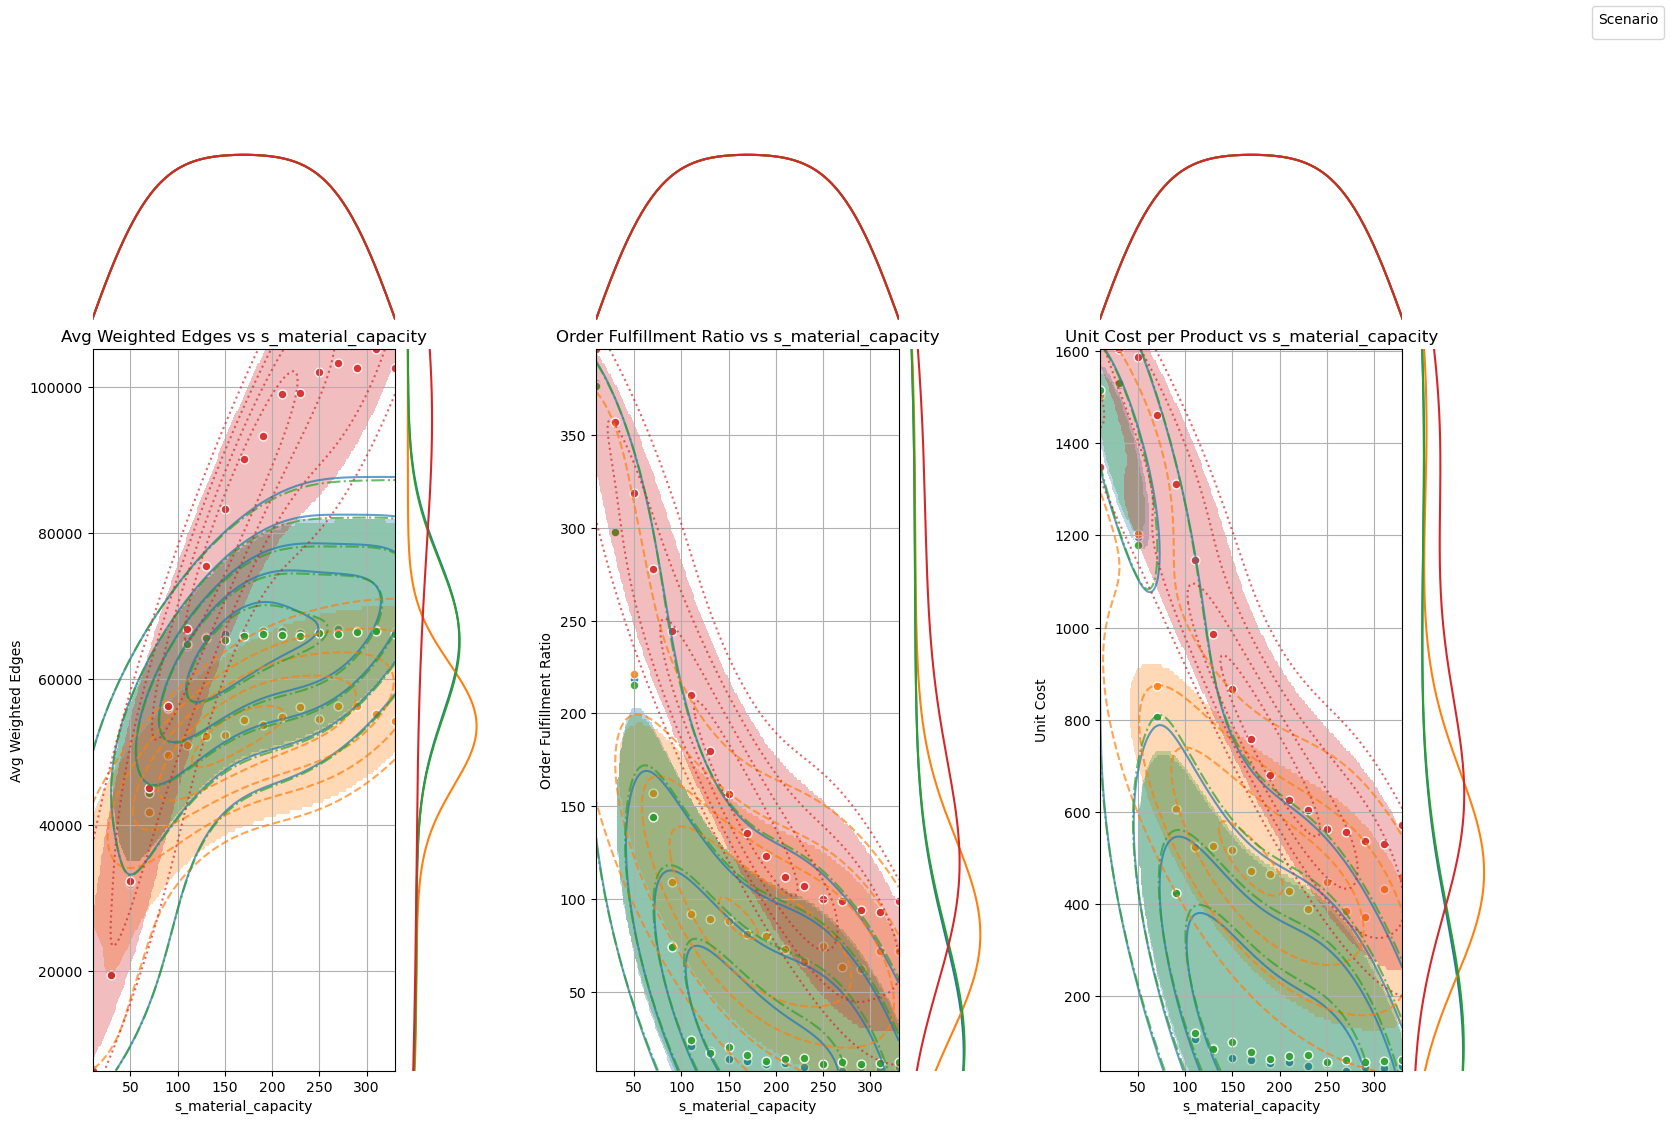

In [7]:
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde

# 场景及样式
scenarios  = ["Default", "Low Production Capacity", "Slow Logistics", "High Demand"]
colors     = ["C0", "C1", "C2","C3"]
linestyles = ['-', '--', '-.', ':']

# 指定六个子图： (metrics_dict, y_index, x_label, y_label, title)
combos = [
    (metrics_smat, 1, 's_material_capacity', 'Avg Weighted Edges',
     'Avg Weighted Edges vs s_material_capacity'),
    (metrics_smat, 2, 's_material_capacity', 'Order Fulfillment Ratio',
     'Order Fulfillment Ratio vs s_material_capacity'),
    (metrics_smat, 3, 's_material_capacity', 'Unit Cost',
     'Unit Cost per Product vs s_material_capacity'),
]

fig = plt.figure(figsize=(18, 12))
outer = GridSpec(1, 3, wspace=0.3, hspace=0.3)

for idx, (metrics_dict, yi, xlab, ylab, title) in enumerate(combos):
    row, col = divmod(idx, 3)
    inner = outer[row, col].subgridspec(
        2, 2,
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        wspace=0.05, hspace=0.05
    )

    ax_main = fig.add_subplot(inner[1, 0])
    ax_x    = fig.add_subplot(inner[0, 0], sharex=ax_main)
    ax_y    = fig.add_subplot(inner[1, 1], sharey=ax_main)

    # 先拿到本图所有场景 x,y 的范围，做公共网格
    all_x = np.hstack([ [t[0] for t in metrics_dict[s]] for s in scenarios ])
    all_y = np.hstack([ [t[yi] for t in metrics_dict[s]] for s in scenarios ])
    xi, yi_grid = np.mgrid[
        all_x.min():all_x.max():200j,
        all_y.min():all_y.max():200j
    ]

    for scen, c, ls in zip(scenarios, colors, linestyles):
        arr = metrics_dict[scen]
        x   = np.array([t[0] for t in arr])
        y   = np.array([t[yi] for t in arr])

        # KDE & 密度矩阵
        kde = gaussian_kde(np.vstack([x, y]))
        zi  = kde(np.vstack([xi.ravel(), yi_grid.ravel()])).reshape(xi.shape)

        # 只填高于 75th 百分位的区域
        thresh  = np.percentile(zi, 75)
        zi_mask = np.ma.masked_less(zi, thresh)
        ax_main.contourf(
            xi, yi_grid, zi_mask,
            levels=[thresh, zi.max()],
            colors=[c],
            alpha=0.3,
            extend='neither'
        )
        # 叠加等高线
        ax_main.contour(
            xi, yi_grid, zi,
            levels=5,
            colors=[c],
            linestyles=ls,
            alpha=0.7
        )
        # 散点
        ax_main.scatter(
            x, y,
            c=c,
            edgecolor='white',
            s=40,
            label=scen if idx==0 else "",  # 只在第一个子图标一次
            alpha=0.9
        )
        # 上方边缘密度
        kde_x = gaussian_kde(x)
        xs    = np.linspace(all_x.min(), all_x.max(), 200)
        ax_x.plot(xs, kde_x(xs), color=c)
        # 右侧边缘密度
        kde_y = gaussian_kde(y)
        ys    = np.linspace(all_y.min(), all_y.max(), 200)
        ax_y.plot(kde_y(ys), ys, color=c)

    # 轴和标题
    ax_main.set_xlabel(xlab)
    ax_main.set_ylabel(ylab)
    ax_main.set_title(title)
    ax_main.grid(True)

    # 隐藏空轴刻度
    ax_x.axis('off')
    ax_y.axis('off')

# 总图例放在右上角
handles, labels = ax_main.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Scenario')

plt.show()

Scan m_prod (High Demand): 100%|████████████████████████████████████████████████████| 36/36 [1:03:55<00:00, 106.55s/it]


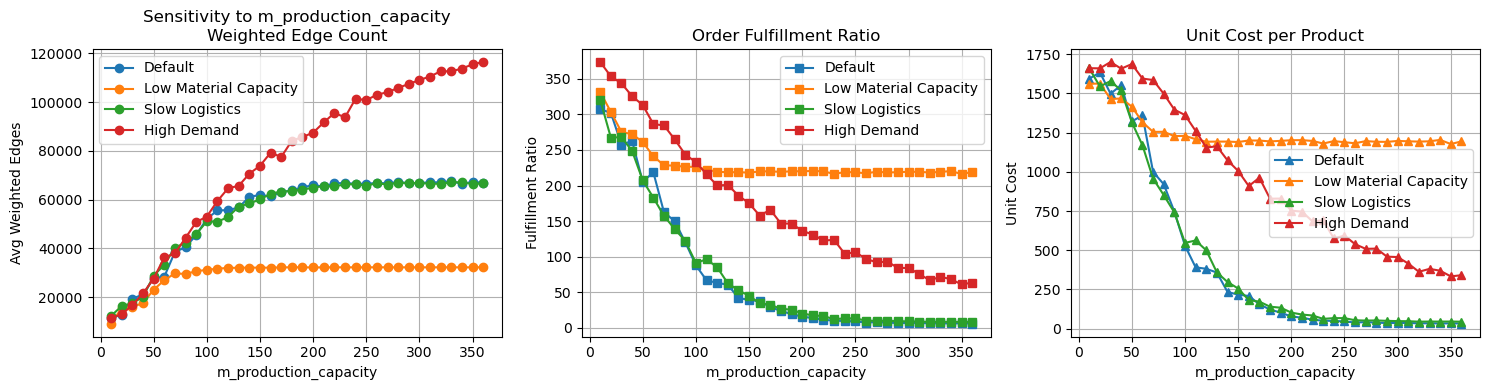

In [9]:
#sensetive for m_prod
from tqdm import tqdm

total_steps = 1000
num_reps    = 5

# 定义三个“静态扰动”场景
scenarios = {
    "Default":       {},
    "Low Material Capacity":{"s_material_capacity": 50},   
    "Slow Logistics":{"logistics_speed": 500},
    "High Demand":   {"cust_demand_multiplier": 2.0}
}

# 要扫描的参数范围
m_prod_range = [10,20, 30, 40, 50, 60,70,80,90,100, 110, 120,130,140,150,160,170, 180, 190, 200, 210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360]


# 存储结果结构
metrics_mprod = { name: [] for name in scenarios }

def eval_static(base_params, override_params):
    """
    base_params: 场景级别的 override dict
    override_params: 本次扫描时要改动的 dict
    """
    # 1) 全部默认参数
    all_params = dict(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,        # baseline
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,         # baseline
        agent_mode="heterogeneous",
        logistics_speed=1000.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=total_steps,
        num_reps=num_reps,
        change_schedule=None,
        return_model=True,
    )
    # 2) 场景级 override
    all_params.update(base_params)
    # 3) 本次扫描 override
    all_params.update(override_params)

    # 4) 一次性调用，不会再出现同名参数冲突
    _, (mean_edge, std_edge, mean_ratio, std_ratio, mean_uc, std_uc) = run_simulation_with_param_changes(**all_params)
    return np.mean(mean_edge), np.mean(mean_ratio), np.mean(mean_uc)


# —— 扫描 m_production_capacity —— 
for name, base_params in scenarios.items():
    for mpc in tqdm(m_prod_range, desc=f"Scan m_prod ({name})"):
        avg_edge, ratio, uc = eval_static(
            base_params,
            {"m_production_capacity": mpc}
        )
        metrics_mprod[name].append((mpc, avg_edge, ratio, uc))


# —— 画图函数 —— 
def plot_three_subplots(metrics, param_label, title_prefix):
    xs = [t[0] for t in next(iter(metrics.values()))]
    fig, axes = plt.subplots(1, 3, figsize=(15,4), sharex=True)

    # 子图1: 加权边数
    ax = axes[0]
    for name,data in metrics.items():
        ax.plot(xs, [t[1] for t in data], marker='o', label=name)
    ax.set(xlabel=param_label, ylabel="Avg Weighted Edges",
           title=title_prefix+"\nWeighted Edge Count")
    ax.grid(); ax.legend()

    # 子图2: 履约率
    ax = axes[1]
    for name,data in metrics.items():
        ax.plot(xs, [t[2] for t in data], marker='s', label=name)
    ax.set(xlabel=param_label, ylabel="Fulfillment Ratio",
           title="Order Fulfillment Ratio")
    ax.grid(); ax.legend()

    # 子图3: 单位成本
    ax = axes[2]
    for name,data in metrics.items():
        ax.plot(xs, [t[3] for t in data], marker='^', label=name)
    ax.set(xlabel=param_label, ylabel="Unit Cost",
           title="Unit Cost per Product")
    ax.grid(); ax.legend()

    plt.tight_layout()
    plt.show()

# 绘制
plot_three_subplots(metrics_mprod,
                   "m_production_capacity",
                   "Sensitivity to m_production_capacity")

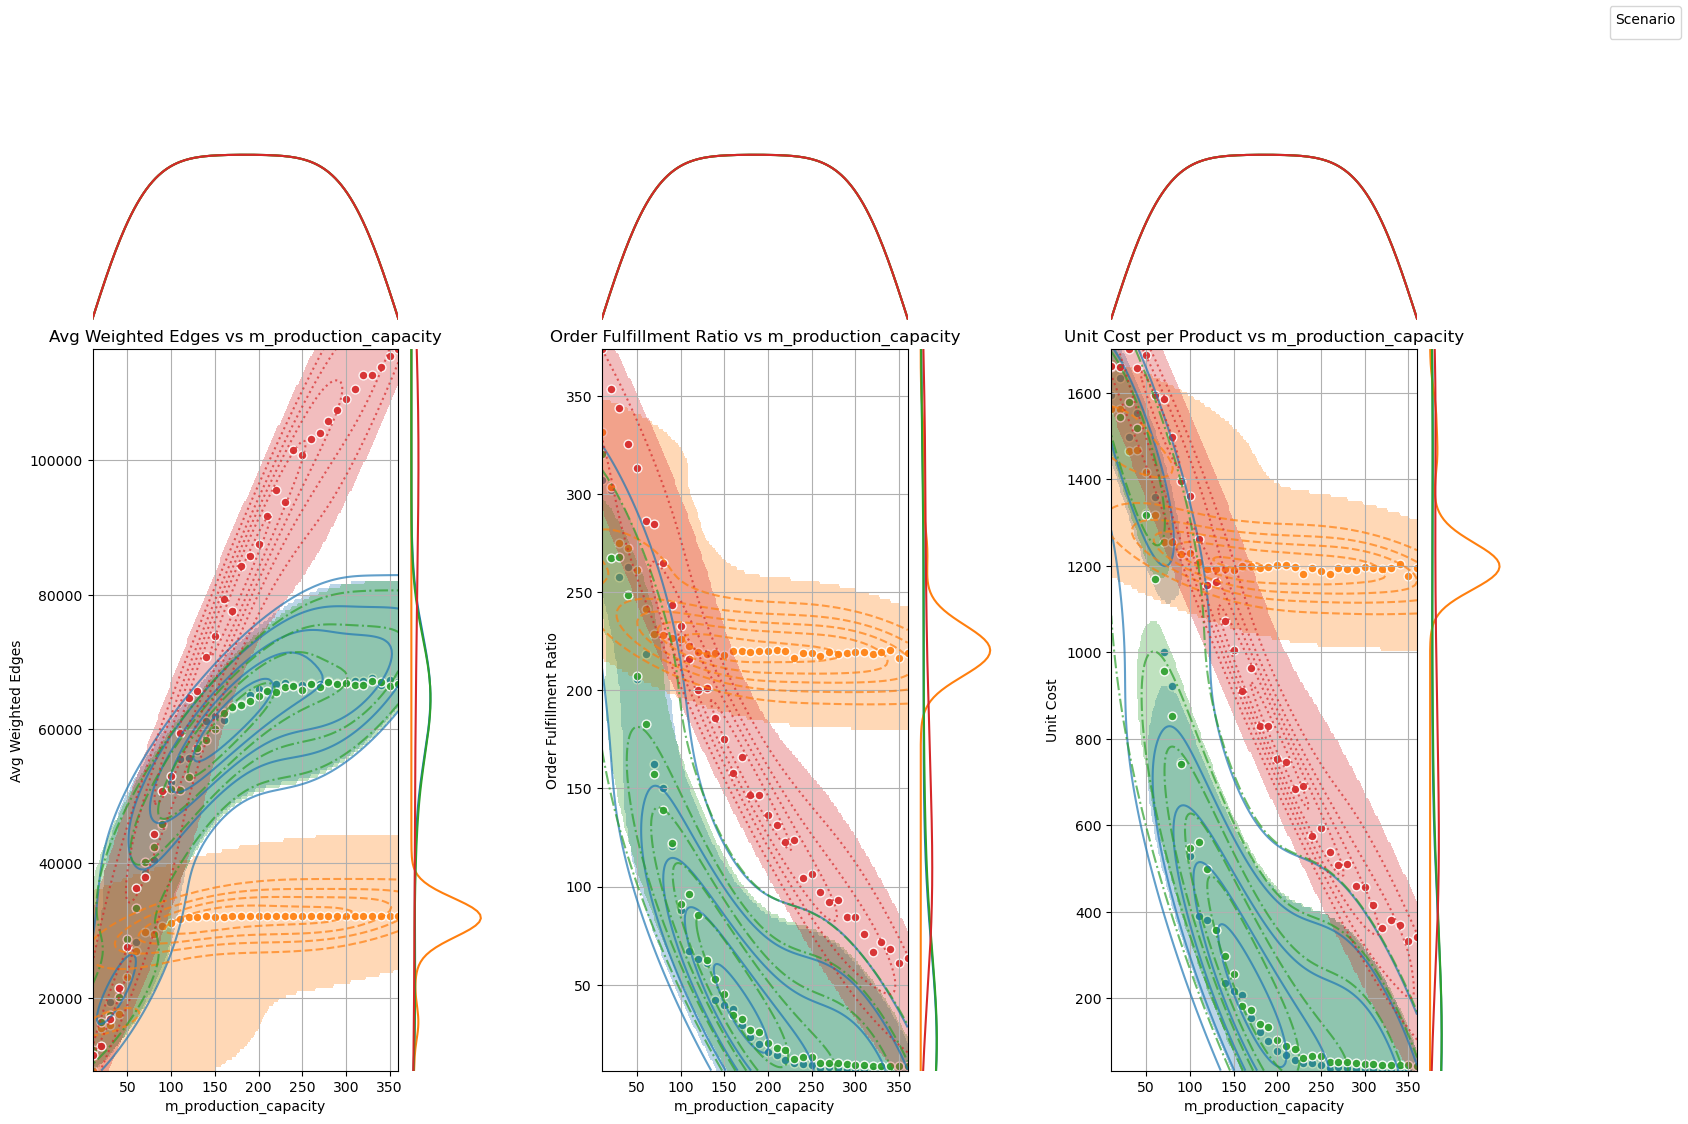

In [10]:
# 场景及样式
scenarios  = ["Default", "Low Material Capacity", "Slow Logistics", "High Demand"]
colors     = ["C0", "C1", "C2","C3"]
linestyles = ['-', '--', '-.',':']

# 指定六个子图： (metrics_dict, y_index, x_label, y_label, title)
combos = [
    (metrics_mprod, 1, 'm_production_capacity', 'Avg Weighted Edges',
     'Avg Weighted Edges vs m_production_capacity'),
    (metrics_mprod, 2, 'm_production_capacity', 'Order Fulfillment Ratio',
     'Order Fulfillment Ratio vs m_production_capacity'),
    (metrics_mprod, 3, 'm_production_capacity', 'Unit Cost',
     'Unit Cost per Product vs m_production_capacity'),
]

fig = plt.figure(figsize=(18.2, 12))
outer = GridSpec(1, 3, wspace=0.3, hspace=0.3)

for idx, (metrics_dict, yi, xlab, ylab, title) in enumerate(combos):
    row, col = divmod(idx, 3)
    inner = outer[row, col].subgridspec(
        2, 2,
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        wspace=0.05, hspace=0.05
    )

    ax_main = fig.add_subplot(inner[1, 0])
    ax_x    = fig.add_subplot(inner[0, 0], sharex=ax_main)
    ax_y    = fig.add_subplot(inner[1, 1], sharey=ax_main)

    # 先拿到本图所有场景 x,y 的范围，做公共网格
    all_x = np.hstack([ [t[0] for t in metrics_dict[s]] for s in scenarios ])
    all_y = np.hstack([ [t[yi] for t in metrics_dict[s]] for s in scenarios ])
    xi, yi_grid = np.mgrid[
        all_x.min():all_x.max():200j,
        all_y.min():all_y.max():200j
    ]

    for scen, c, ls in zip(scenarios, colors, linestyles):
        arr = metrics_dict[scen]
        x   = np.array([t[0] for t in arr])
        y   = np.array([t[yi] for t in arr])

        # KDE & 密度矩阵
        kde = gaussian_kde(np.vstack([x, y]))
        zi  = kde(np.vstack([xi.ravel(), yi_grid.ravel()])).reshape(xi.shape)

        # 只填高于 75th 百分位的区域
        thresh  = np.percentile(zi, 75)
        zi_mask = np.ma.masked_less(zi, thresh)
        ax_main.contourf(
            xi, yi_grid, zi_mask,
            levels=[thresh, zi.max()],
            colors=[c],
            alpha=0.3,
            extend='neither'
        )
        # 叠加等高线
        ax_main.contour(
            xi, yi_grid, zi,
            levels=5,
            colors=[c],
            linestyles=ls,
            alpha=0.7
        )
        # 散点
        ax_main.scatter(
            x, y,
            c=c,
            edgecolor='white',
            s=40,
            label=scen if idx==0 else "",  # 只在第一个子图标一次
            alpha=0.9
        )
        # 上方边缘密度
        kde_x = gaussian_kde(x)
        xs    = np.linspace(all_x.min(), all_x.max(), 200)
        ax_x.plot(xs, kde_x(xs), color=c)
        # 右侧边缘密度
        kde_y = gaussian_kde(y)
        ys    = np.linspace(all_y.min(), all_y.max(), 200)
        ax_y.plot(kde_y(ys), ys, color=c)

    # 轴和标题
    ax_main.set_xlabel(xlab)
    ax_main.set_ylabel(ylab)
    ax_main.set_title(title)
    ax_main.grid(True)

    # 隐藏空轴刻度
    ax_x.axis('off')
    ax_y.axis('off')

# 总图例放在右上角
handles, labels = ax_main.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Scenario')

plt.show()

In [12]:
!pip install SALib

   ---------------------------------------- 0.0/778.9 kB ? eta -:--:--
   --------------------------------------- 778.9/778.9 kB 11.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   -------------- ------------------------- 4.2/11.3 MB 19.4 MB/s eta 0:00:01
   --------------------------------- ------ 9.4/11.3 MB 23.5 MB/s eta 0:00:01
   ---------------------------------------- 11.3/11.3 MB 22.9 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3


  You can safely remove it manually.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
def eval_static(base_params, override_params):
    """
    base_params: 场景级别的 override dict
    override_params: 本次扫描时要改动的 dict
    """
    # 1) 全部默认参数
    all_params = dict(
        cust_demand_multiplier=1.0,
        m_production_capacity=230,        # baseline
        m_inventory_capacity_product=700,
        m_inventory_capacity_material=1000,
        s_material_capacity=200,         # baseline
        agent_mode="heterogeneous",
        logistics_speed=1000.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=400,
        rm_reorder_target=900,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.2,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=1000,
        num_reps=1,
        change_schedule=None,
        return_model=True,
    )
    # 2) 场景级 override
    all_params.update(base_params)
    # 3) 本次扫描 override
    all_params.update(override_params)

    # 4) 一次性调用，不会再出现同名参数冲突
    _, (mean_edge, std_edge, mean_ratio, std_ratio, mean_uc, std_uc) = run_simulation_with_param_changes(**all_params)
    return np.mean(mean_edge),np.mean(mean_ratio), np.mean(mean_uc)


In [17]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import sobol
from SALib.analyze.sobol import analyze      # sobol 仍然是一个“模块”
def _to_scalar(x):
    """确保传入 int()/float() 的一定是 Python 标量"""
    if isinstance(x, np.ndarray):
        return x.item()
    return x

def eval_static(base_params: dict, override_params: dict):
    """
    1 次仿真，返回 (平均边权, 履约率, 单位成本) 三指标
    （如有更多指标，可以相应地修改代码）
    """
    # ---------- 1) 默认参数 ----------
    all_params = dict(
        cust_demand_multiplier          = 1.0,
        m_production_capacity           = 230,
        m_inventory_capacity_product    = 700,
        m_inventory_capacity_material   = 1000,
        s_material_capacity             = 200,
        agent_mode                      = "heterogeneous",
        logistics_speed                 = 1000.0,
        rm_procurement_mode             = "gap_based",
        rm_reorder_point                = 400,
        rm_reorder_target               = 900,
        rm_purchase_multiplier          = 1.2,
        rm_produce_multiplier           = 1.2,
        product_order_mode              = "normal",
        material_order_mode             = "normal",
        total_steps                     = 1000,
        num_reps                        = 1,
        change_schedule                 = None,
        return_model                    = True,
    )

    # ---------- 2) 覆盖参数 ----------
    all_params.update({k: _to_scalar(v) for k, v in base_params.items()})
    all_params.update({k: _to_scalar(v) for k, v in override_params.items()})

    # ---------- 3) 仅“需要整数”的键做强制取整 ----------
    int_keys = [
        "s_material_capacity",
        "m_production_capacity",
        "m_inventory_capacity_product",
        "m_inventory_capacity_material",
        "rm_reorder_point",
        "rm_reorder_target",
    ]
    for k in int_keys:
        if k in all_params:
            all_params[k] = max(1, int(round(all_params[k])))

    # ---------- 4) 调用仿真 ----------
    _, (
        mean_edge, _,
        mean_ratio, _,
        mean_uc,   _
    ) = run_simulation_with_param_changes(**all_params)

    return np.mean(mean_edge), np.mean(mean_ratio), np.mean(mean_uc)


# ===========================================================
# 3) Sobol “problem” 设置
# ===========================================================
problem = {
    "num_vars": 8,
    "names": [
        "s_material_capacity",
        "m_production_capacity",
        "logistics_speed",
        "cust_demand_multiplier",
        "rm_purchase_multiplier",
        "rm_produce_multiplier",
        "m_inventory_capacity_product",
        "m_inventory_capacity_material",
    ],
    "bounds": [
        [10,  2000 ],   # int
        [10,   2000],   # int
        [200,  10000],  # float
        [1.0,  2.0],    # float
        [1.0,  2.0],    # float
        [1.0,  2.0],    # float
        [50,  10000],   # int
        [50,  10000],   # int
    ],
}

# ===========================================================
# 4) Saltelli–Sobol 采样
# ===========================================================
N_BASE = 4                      # 示范用小样本；实际请加大 N_BASE
np.random.seed(42)
param_values = sobol.sample(problem, N_BASE, calc_second_order=True)
print(f"Total simulations needed: {param_values.shape[0]}")

# ===========================================================
# 5) 运行模型
# ===========================================================
def run_one_sim(sample_row):
    override = {k: v for k, v in zip(problem["names"], sample_row)}
    try:
        return eval_static({}, override)
    except Exception as e:
        # 打印更友好的日志，同时返回 nan，方便后续过滤
        print(f"[WARN] sim failed with params {override} -> {e}")
        return np.nan, np.nan, np.nan

results = []
for row in tqdm(param_values, desc="Running model"):
    results.append(run_one_sim(row))
Y = np.array(results, dtype=float)          # shape = (samples, 3)

# 如果某些仿真失败，用 nan 作标记，Sobol 不接受 nan，需要先剔除
mask = ~np.isnan(Y).any(axis=1)
if mask.sum() < Y.shape[0]:
    print(f"[INFO] filtered out {Y.shape[0]-mask.sum()} failed runs")
Y = Y[mask]
param_values_valid = param_values[mask]

# ===========================================================
# 6) Sobol 方差分解 & 保存
# ===========================================================
def sobol_df(y, metric):
    Si = analyze(problem, y, calc_second_order=True, print_to_console=False)
    return (
        pd.DataFrame({
            "parameter": problem["names"],
            "S1":  Si["S1"],
            "ST":  Si["ST"]
        })
        .assign(metric=metric)
    )

full_table = pd.concat([
    sobol_df(Y[:, 0], "AvgWeightedEdge"),
    sobol_df(Y[:, 1], "FulfillmentRatio"),
    sobol_df(Y[:, 2], "UnitCost"),
], ignore_index=True)

print(full_table)
full_table.to_csv("sobol_indices.csv", index=False)
print("Sobol results saved → sobol_indices.csv")

Total simulations needed: 72


Running model: 100%|███████████████████████████████████████████████████████████████████| 72/72 [24:04<00:00, 20.06s/it]

                        parameter        S1        ST            metric
0             s_material_capacity -0.016785  0.000875   AvgWeightedEdge
1           m_production_capacity  0.083100  0.007310   AvgWeightedEdge
2                 logistics_speed -0.038290  0.006417   AvgWeightedEdge
3          cust_demand_multiplier  0.606311  0.834684   AvgWeightedEdge
4          rm_purchase_multiplier -0.045151  0.005103   AvgWeightedEdge
5           rm_produce_multiplier  0.024014  0.006459   AvgWeightedEdge
6    m_inventory_capacity_product  0.019500  0.002995   AvgWeightedEdge
7   m_inventory_capacity_material -0.081861  0.018439   AvgWeightedEdge
8             s_material_capacity  0.018014  0.001827  FulfillmentRatio
9           m_production_capacity -0.028175  0.004954  FulfillmentRatio
10                logistics_speed  0.003981  0.000335  FulfillmentRatio
11         cust_demand_multiplier  0.131233  0.598385  FulfillmentRatio
12         rm_purchase_multiplier  0.002564  0.006402  Fulfillme


D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [19]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import sobol
from SALib.analyze.sobol import analyze  

# --------------------------------------------------
# 1) 仿真接口（保持你的实现）
# --------------------------------------------------
def _to_scalar(x):
    """确保 int()/float() 的参数是 Python 标量而不是 0d-ndarray"""
    if isinstance(x, np.ndarray):
        return x.item()
    return x


def eval_static(base_params: dict, override_params: dict):
    """
    单次仿真 → 返回三指标 (avg_edge, fulfill_ratio, unit_cost)
    这里只粘贴框架；内部仍调用你已有的 run_simulation_with_param_changes
    """
    # 1. 默认参数
    all_params = dict(
        cust_demand_multiplier          = 1.0,
        m_production_capacity           = 230,
        m_inventory_capacity_product    = 700,
        m_inventory_capacity_material   = 1000,
        s_material_capacity             = 200,
        agent_mode                      = "heterogeneous",
        logistics_speed                 = 1000.0,
        rm_procurement_mode             = "gap_based",
        rm_reorder_point                = 400,
        rm_reorder_target               = 900,
        rm_purchase_multiplier          = 1.2,
        rm_produce_multiplier           = 1.2,
        product_order_mode              = "normal",
        material_order_mode             = "normal",
        total_steps                     = 1000,
        num_reps                        = 1,
        change_schedule                 = None,
        return_model                    = True,
    )

    # 2. 覆盖参数
    all_params.update({k: _to_scalar(v) for k, v in base_params.items()})
    all_params.update({k: _to_scalar(v) for k, v in override_params.items()})

    # 3. 需要整数的键强制取整
    int_keys = [
        "s_material_capacity",
        "m_production_capacity",
        "m_inventory_capacity_product",
        "m_inventory_capacity_material",
        "rm_reorder_point",
        "rm_reorder_target",
    ]
    for k in int_keys:
        if k in all_params:
            all_params[k] = max(1, int(round(all_params[k])))

    # 4. 调用真正的仿真函数
    _, (
        mean_edge, _,
        mean_ratio, _,
        mean_uc,   _
    ) = run_simulation_with_param_changes(**all_params)

    return np.mean(mean_edge), np.mean(mean_ratio), np.mean(mean_uc)


# --------------------------------------------------
# 2) 变量配置：name, lower, upper, scale
# --------------------------------------------------
VARIABLES = [
    ("s_material_capacity",          10,    2000,  "log"),
    ("m_production_capacity",        10,    2000,  "log"),
    ("logistics_speed",              200,   10000, "log"),
    ("cust_demand_multiplier",       1.0,   2.0,   "linear"),
    ("rm_purchase_multiplier",       1.0,   2.0,   "linear"),
    ("rm_produce_multiplier",        1.0,   2.0,   "linear"),
    ("m_inventory_capacity_product", 50,    10000, "log"),
    ("m_inventory_capacity_material",50,    10000, "log"),
]

# --------------------------------------------------
# 3) SALib “problem” 构造（按缩放方式决定 bounds）
# --------------------------------------------------
problem = {
    "num_vars": len(VARIABLES),
    "names":   [v[0] for v in VARIABLES],
    "bounds":  [
        [np.log10(lo), np.log10(hi)] if scale == "log" else [lo, hi]
        for (_, lo, hi, scale) in VARIABLES
    ],
}

# --------------------------------------------------
# 4) Saltelli–Sobol 采样
# --------------------------------------------------
N_BASE = 2                     # demo：实际请 > 256
np.random.seed(42)
param_values = sobol.sample(problem, N_BASE, calc_second_order=True)
print(f"Total simulations needed: {param_values.shape[0]}")

# --------------------------------------------------
# 5) 反变换：采样空间 -> 物理空间
# --------------------------------------------------
def sample_to_physical(sample_row):
    """row 是一维 array，输出 dict"""
    override = {}
    for (name, lo, hi, scale), val in zip(VARIABLES, sample_row):
        if scale == "log":
            phys = 10 ** val      # log10^-1
        else:
            phys = val
        override[name] = phys
    return override

# --------------------------------------------------
# 6) 跑模型
# --------------------------------------------------
def run_one_sim(sample_row):
    override = sample_to_physical(sample_row)
    try:
        return eval_static({}, override)
    except Exception as e:
        print(f"[WARN] sim failed with params {override} -> {e}")
        return np.nan, np.nan, np.nan


results = []
for row in tqdm(param_values, desc="Running model"):
    results.append(run_one_sim(row))

Y = np.array(results, dtype=float)

# 过滤失败 / nan
mask = ~np.isnan(Y).any(axis=1)
if mask.sum() < Y.shape[0]:
    print(f"[INFO] filtered out {Y.shape[0]-mask.sum()} failed runs")
Y_valid = Y[mask]
param_valid = param_values[mask]

# --------------------------------------------------
# 7) Sobol 方差分解
# --------------------------------------------------
def sobol_df(y, metric):
    Si = analyze(problem, y, calc_second_order=True, print_to_console=False)
    return (
        pd.DataFrame({
            "parameter": problem["names"],
            "S1": Si["S1"],
            "ST": Si["ST"],
        })
        .assign(metric=metric)
    )

full_table = pd.concat([
    sobol_df(Y_valid[:, 0], "AvgWeightedEdge"),
    sobol_df(Y_valid[:, 1], "FulfillmentRatio"),
    sobol_df(Y_valid[:, 2], "UnitCost"),
], ignore_index=True)

print(full_table)
full_table.to_csv("sobol_indices.csv", index=False)
print("Sobol results saved → sobol_indices.csv")

Total simulations needed: 36


Running model: 100%|███████████████████████████████████████████████████████████████████| 36/36 [15:56<00:00, 26.56s/it]

                        parameter        S1        ST            metric
0             s_material_capacity  1.176868  0.418479   AvgWeightedEdge
1           m_production_capacity -0.171297  0.164757   AvgWeightedEdge
2                 logistics_speed  0.019338  0.002628   AvgWeightedEdge
3          cust_demand_multiplier  0.042636  0.010884   AvgWeightedEdge
4          rm_purchase_multiplier -0.009676  0.000583   AvgWeightedEdge
5           rm_produce_multiplier  0.019135  0.001463   AvgWeightedEdge
6    m_inventory_capacity_product  0.014943  0.000568   AvgWeightedEdge
7   m_inventory_capacity_material -0.016867  0.002857   AvgWeightedEdge
8             s_material_capacity  1.381074  0.638190  FulfillmentRatio
9           m_production_capacity -0.401327  0.468345  FulfillmentRatio
10                logistics_speed -0.081097  0.003112  FulfillmentRatio
11         cust_demand_multiplier  0.046417  0.068559  FulfillmentRatio
12         rm_purchase_multiplier -0.019051  0.000441  Fulfillme


D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import sobol
from SALib.analyze.sobol import analyze  

# --------------------------------------------------
# 1) 仿真接口（保持你的实现）
# --------------------------------------------------
def _to_scalar(x):
    """确保 int()/float() 的参数是 Python 标量而不是 0d-ndarray"""
    if isinstance(x, np.ndarray):
        return x.item()
    return x


def eval_static(base_params: dict, override_params: dict):
    """
    单次仿真 → 返回三指标 (avg_edge, fulfill_ratio, unit_cost)
    这里只粘贴框架；内部仍调用你已有的 run_simulation_with_param_changes
    """
    # 1. 默认参数
    all_params = dict(
        cust_demand_multiplier          = 1.0,
        m_production_capacity           = 230,
        m_inventory_capacity_product    = 700,
        m_inventory_capacity_material   = 1000,
        s_material_capacity             = 200,
        agent_mode                      = "heterogeneous",
        logistics_speed                 = 1000.0,
        rm_procurement_mode             = "gap_based",
        rm_reorder_point                = 400,
        rm_reorder_target               = 900,
        rm_purchase_multiplier          = 1.2,
        rm_produce_multiplier           = 1.2,
        product_order_mode              = "normal",
        material_order_mode             = "normal",
        total_steps                     = 1000,
        num_reps                        = 1,
        change_schedule                 = None,
        return_model                    = True,
    )

    # 2. 覆盖参数
    all_params.update({k: _to_scalar(v) for k, v in base_params.items()})
    all_params.update({k: _to_scalar(v) for k, v in override_params.items()})

    # 3. 需要整数的键强制取整
    int_keys = [
        "s_material_capacity",
        "m_production_capacity",
        "m_inventory_capacity_product",
        "m_inventory_capacity_material",
        "rm_reorder_point",
        "rm_reorder_target",
    ]
    for k in int_keys:
        if k in all_params:
            all_params[k] = max(1, int(round(all_params[k])))

    # 4. 调用真正的仿真函数
    _, (
        mean_edge, _,
        mean_ratio, _,
        mean_uc,   _
    ) = run_simulation_with_param_changes(**all_params)

    return np.mean(mean_edge), np.mean(mean_ratio), np.mean(mean_uc)


# --------------------------------------------------
# 2) 变量配置：name, lower, upper, scale
# --------------------------------------------------
VARIABLES = [
    ("s_material_capacity",          50,    500,  "log"),
    ("m_production_capacity",        50,    500,  "log"),
    ("logistics_speed",              300,   5000, "log"),
    ("rm_purchase_multiplier",       1.0,   2.0,   "linear"),
    ("rm_produce_multiplier",        1.0,   2.0,   "linear"),
    ("m_inventory_capacity_product", 200,    2000, "log"),
    ("m_inventory_capacity_material",300,    3000, "log"),
]

# --------------------------------------------------
# 3) SALib “problem” 构造（按缩放方式决定 bounds）
# --------------------------------------------------
problem = {
    "num_vars": len(VARIABLES),
    "names":   [v[0] for v in VARIABLES],
    "bounds":  [
        [np.log10(lo), np.log10(hi)] if scale == "log" else [lo, hi]
        for (_, lo, hi, scale) in VARIABLES
    ],
}

# --------------------------------------------------
# 4) Saltelli–Sobol 采样
# --------------------------------------------------
N_BASE = 128                     # demo：实际请 > 256
np.random.seed(42)
param_values = sobol.sample(problem, N_BASE, calc_second_order=True)
print(f"Total simulations needed: {param_values.shape[0]}")

# --------------------------------------------------
# 5) 反变换：采样空间 -> 物理空间
# --------------------------------------------------
def sample_to_physical(sample_row):
    """row 是一维 array，输出 dict"""
    override = {}
    for (name, lo, hi, scale), val in zip(VARIABLES, sample_row):
        if scale == "log":
            phys = 10 ** val      # log10^-1
        else:
            phys = val
        override[name] = phys
    return override

# --------------------------------------------------
# 6) 跑模型
# --------------------------------------------------
def run_one_sim(sample_row):
    override = sample_to_physical(sample_row)
    try:
        return eval_static({}, override)
    except Exception as e:
        print(f"[WARN] sim failed with params {override} -> {e}")
        return np.nan, np.nan, np.nan


results = []
for row in tqdm(param_values, desc="Running model"):
    results.append(run_one_sim(row))

Y = np.array(results, dtype=float)

# 过滤失败 / nan
mask = ~np.isnan(Y).any(axis=1)
if mask.sum() < Y.shape[0]:
    print(f"[INFO] filtered out {Y.shape[0]-mask.sum()} failed runs")
Y_valid = Y[mask]
param_valid = param_values[mask]

# --------------------------------------------------
# 7) Sobol 方差分解
# --------------------------------------------------
def sobol_df(y, metric):
    Si = analyze(problem, y, calc_second_order=True, print_to_console=False)
    return (
        pd.DataFrame({
            "parameter": problem["names"],
            "S1": Si["S1"],
            "ST": Si["ST"],
        })
        .assign(metric=metric)
    )

full_table = pd.concat([
    sobol_df(Y_valid[:, 0], "AvgWeightedEdge"),
    sobol_df(Y_valid[:, 1], "FulfillmentRatio"),
    sobol_df(Y_valid[:, 2], "UnitCost"),
], ignore_index=True)

print(full_table)
full_table.to_csv("sobol_indices.csv", index=False)
print("Sobol results saved → sobol_indices.csv")

Total simulations needed: 2048


Running model: 100%|████████████████████████████████████████████████████████████| 2048/2048 [12:19:36<00:00, 21.67s/it]
D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                        parameter        S1        ST            metric
0             s_material_capacity  0.349994  0.417590   AvgWeightedEdge
1           m_production_capacity  0.552865  0.719678   AvgWeightedEdge
2                 logistics_speed -0.007666  0.020154   AvgWeightedEdge
3          rm_purchase_multiplier  0.003347  0.019128   AvgWeightedEdge
4           rm_produce_multiplier -0.013501  0.025430   AvgWeightedEdge
5    m_inventory_capacity_product  0.011866  0.022045   AvgWeightedEdge
6   m_inventory_capacity_material -0.010230  0.027779   AvgWeightedEdge
7             s_material_capacity  0.433800  0.513519  FulfillmentRatio
8           m_production_capacity  0.472288  0.644393  FulfillmentRatio
9                 logistics_speed -0.007666  0.028086  FulfillmentRatio
10         rm_purchase_multiplier  0.007166  0.024594  FulfillmentRatio
11          rm_produce_multiplier -0.004162  0.030822  FulfillmentRatio
12   m_inventory_capacity_product  0.007242  0.027418  Fulfillme

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import sobol
from SALib.analyze.sobol import analyze  

# --------------------------------------------------
# 1) 仿真接口（保持你的实现）
# --------------------------------------------------
def _to_scalar(x):
    """确保 int()/float() 的参数是 Python 标量而不是 0d-ndarray"""
    if isinstance(x, np.ndarray):
        return x.item()
    return x


def eval_static(base_params: dict, override_params: dict):
    """
    单次仿真 → 返回三指标 (avg_edge, fulfill_ratio, unit_cost)
    这里只粘贴框架；内部仍调用你已有的 run_simulation_with_param_changes
    """
    # 1. 默认参数
    all_params = dict(
        cust_demand_multiplier          = 1.0,
        m_production_capacity           = 230,
        m_inventory_capacity_product    = 700,
        m_inventory_capacity_material   = 1000,
        s_material_capacity             = 200,
        agent_mode                      = "heterogeneous",
        logistics_speed                 = 1000.0,
        rm_procurement_mode             = "gap_based",
        rm_reorder_point                = 400,
        rm_reorder_target               = 900,
        rm_purchase_multiplier          = 1.2,
        rm_produce_multiplier           = 1.2,
        product_order_mode              = "normal",
        material_order_mode             = "normal",
        total_steps                     = 1000,
        num_reps                        = 1,
        change_schedule                 = None,
        return_model                    = True,
    )

    # 2. 覆盖参数
    all_params.update({k: _to_scalar(v) for k, v in base_params.items()})
    all_params.update({k: _to_scalar(v) for k, v in override_params.items()})

    # 3. 需要整数的键强制取整
    int_keys = [
        "s_material_capacity",
        "m_production_capacity",
        "m_inventory_capacity_product",
        "m_inventory_capacity_material",
        "rm_reorder_point",
        "rm_reorder_target",
    ]
    for k in int_keys:
        if k in all_params:
            all_params[k] = max(1, int(round(all_params[k])))

    # 4. 调用真正的仿真函数
    _, (
        mean_edge, _,
        mean_ratio, _,
        mean_uc,   _
    ) = run_simulation_with_param_changes(**all_params)

    return mean_edge[-1], mean_ratio[-1], mean_uc[-1]

# --------------------------------------------------
# 2) 变量配置：name, lower, upper, scale
# --------------------------------------------------
VARIABLES = [
    ("s_material_capacity",          50,    500,  "log"),
    ("m_production_capacity",        50,    500,  "log"),
    ("logistics_speed",              500,   10000, "log"),
    ("rm_purchase_multiplier",       1.0,   2.0,   "linear"),
    ("rm_produce_multiplier",        1.0,   2.0,   "linear"),
    ("m_inventory_capacity_product", 200,    2000, "log"),
    ("m_inventory_capacity_material",300,    3000, "log"),
]

# --------------------------------------------------
# 3) SALib “problem” 构造（按缩放方式决定 bounds）
# --------------------------------------------------
problem = {
    "num_vars": len(VARIABLES),
    "names":   [v[0] for v in VARIABLES],
    "bounds":  [
        [np.log10(lo), np.log10(hi)] if scale == "log" else [lo, hi]
        for (_, lo, hi, scale) in VARIABLES
    ],
}

# --------------------------------------------------
# 4) Saltelli–Sobol 采样
# --------------------------------------------------
N_BASE = 128                     # demo：实际请 > 256
np.random.seed(42)
param_values = sobol.sample(problem, N_BASE, calc_second_order=True)
print(f"Total simulations needed: {param_values.shape[0]}")

# --------------------------------------------------
# 5) 反变换：采样空间 -> 物理空间
# --------------------------------------------------
def sample_to_physical(sample_row):
    """row 是一维 array，输出 dict"""
    override = {}
    for (name, lo, hi, scale), val in zip(VARIABLES, sample_row):
        if scale == "log":
            phys = 10 ** val      # log10^-1
        else:
            phys = val
        override[name] = phys
    return override

# --------------------------------------------------
# 6) 跑模型
# --------------------------------------------------
def run_one_sim(sample_row):
    override = sample_to_physical(sample_row)
    try:
        return eval_static({}, override)
    except Exception as e:
        print(f"[WARN] sim failed with params {override} -> {e}")
        return np.nan, np.nan, np.nan


results = []
for row in tqdm(param_values, desc="Running model"):
    results.append(run_one_sim(row))

Y = np.array(results, dtype=float)

# 过滤失败 / nan
mask = ~np.isnan(Y).any(axis=1)
if mask.sum() < Y.shape[0]:
    print(f"[INFO] filtered out {Y.shape[0]-mask.sum()} failed runs")
Y_valid = Y[mask]
param_valid = param_values[mask]

# --------------------------------------------------
# 7) Sobol 方差分解
# --------------------------------------------------
def sobol_df(y, metric):
    Si = analyze(problem, y, calc_second_order=True, print_to_console=False)
    return (
        pd.DataFrame({
            "parameter": problem["names"],
            "S1": Si["S1"],
            "ST": Si["ST"],
        })
        .assign(metric=metric)
    )

full_table = pd.concat([
    sobol_df(Y_valid[:, 0], "AvgWeightedEdge"),
    sobol_df(Y_valid[:, 1], "FulfillmentRatio"),
    sobol_df(Y_valid[:, 2], "UnitCost"),
], ignore_index=True)

print(full_table)
full_table.to_csv("sobol_indices1.csv", index=False)
print("Sobol results saved → sobol_indices1.csv")

Total simulations needed: 2048


Running model: 100%|████████████████████████████████████████████████████████████| 2048/2048 [12:29:39<00:00, 21.96s/it]
D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                        parameter        S1        ST            metric
0             s_material_capacity  0.340981  0.406599   AvgWeightedEdge
1           m_production_capacity  0.583503  0.693826   AvgWeightedEdge
2                 logistics_speed  0.034129  0.048840   AvgWeightedEdge
3          rm_purchase_multiplier  0.036592  0.056641   AvgWeightedEdge
4           rm_produce_multiplier  0.052126  0.050504   AvgWeightedEdge
5    m_inventory_capacity_product  0.007291  0.062241   AvgWeightedEdge
6   m_inventory_capacity_material  0.044385  0.064955   AvgWeightedEdge
7             s_material_capacity  0.406932  0.446145  FulfillmentRatio
8           m_production_capacity  0.490465  0.591411  FulfillmentRatio
9                 logistics_speed  0.027604  0.022110  FulfillmentRatio
10         rm_purchase_multiplier  0.022418  0.017374  FulfillmentRatio
11          rm_produce_multiplier  0.004994  0.029716  FulfillmentRatio
12   m_inventory_capacity_product  0.010113  0.031791  Fulfillme

D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [13]:
from SALib.sample import latin
from SALib.analyze.delta import analyze  as delta_analyze
from SALib.analyze.pawn  import analyze  as pawn_analyze

# ---------- 0) 已有对象 ----------
# VARIABLES, problem, eval_static 已在环境中
# 若已做过 Sobol，可直接忽略

# ---------- 1) 采样 ----------
N_RANDOM = 2000          # 建议按算力调大
lhs_X    = latin.sample(problem, N_RANDOM, seed=42)

# ---------- 2) 反变换 ----------
def to_phys(x):
    """SALib 样本 → 物理量。既支持 1D，也支持 2D。"""
    X = np.asarray(x, float)
    if X.ndim == 1:      # 单行
        for i, (_, lo, hi, scale) in enumerate(VARIABLES):
            if scale == "log":
                X[i] = 10 ** X[i]
        return X
    else:                # 批量
        Xp = X.copy()
        for i, (_, lo, hi, scale) in enumerate(VARIABLES):
            if scale == "log":
                Xp[:, i] = 10 ** Xp[:, i]
        return Xp

# ---------- 3) 批量仿真 ----------
def run_batch(X):
    """返回 (n_samples, 3) → 三个指标"""
    Y = np.empty((X.shape[0], 3))
    for i, row in enumerate(tqdm(X, desc="Sim")):
        phys_row = to_phys(row)
        Y[i, :] = eval_static({}, dict(zip(problem["names"], phys_row)))
    return Y

Y_lhs = run_batch(lhs_X)

# ---------- 4) 敏感度分析 ----------
def delta_df(y_col, metric):
    Si = delta_analyze(problem, lhs_X, y_col, print_to_console=False)
    return pd.DataFrame({
        "parameter": problem["names"],
        "method"   : "Delta",
        "index"    : ["delta"] * problem["num_vars"],
        "value"    : Si["delta"],
        "metric"   : metric
    })

def pawn_df(y_col, metric, n_bins=10):
    Si = pawn_analyze(problem, lhs_X, y_col,
                      n_bins=n_bins, print_to_console=False)
    return pd.DataFrame({
        "parameter": problem["names"],
        "method"   : "PAWN",
        "index"    : ["p_mu"] * problem["num_vars"],
        "value"    : Si["Mu_star"],
        "metric"   : metric
    })

# ---------- 5) 汇总结果 ----------
metrics = ["AvgEdge", "FulfillRatio", "UnitCost"]
dfs = []

for k, m in enumerate(metrics):
    dfs.append(delta_df(Y_lhs[:, k], m))
    dfs.append(pawn_df (Y_lhs[:, k], m))

gsa_tbl = pd.concat(dfs, ignore_index=True)
gsa_tbl.to_csv("delta_pawn_indices.csv", index=False)
print("Delta & PAWN 指标保存至 delta_pawn_indices.csv")

Sim: 100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [12:13:10<00:00, 22.00s/it]


AttributeError: module 'numpy' has no attribute 'trapezoid'

In [24]:
import numpy as np

# ------------- 1) 临时修补 numpy.trapezoid -----------------
if not hasattr(np, "trapezoid"):          # NumPy<1.20 没有该函数
    def _trapezoid(y, x=None, dx=1.0):
        return np.trapz(y, x=x, dx=dx)    # 退回到 np.trapz
    np.trapezoid = _trapezoid
# -----------------------------------------------------------

import pandas as pd
from SALib.analyze.delta import analyze  as delta_analyze
from SALib.analyze.pawn  import analyze  as pawn_analyze

# ---------- 2) 下面直接用内存里的 lhs_X / Y_lhs ----------
# 此处 problem、VARIABLES 已经在你的会话里
# -----------------------------------------------------------

def delta_df(y_col, metric):
    Si = delta_analyze(problem, lhs_X, y_col, print_to_console=False)
    return pd.DataFrame({
        "parameter": problem["names"],
        "method"   : "Delta",
        "index"    : ["delta"] * problem["num_vars"],
        "value"    : Si["delta"],
        "metric"   : metric,
    })

def pawn_df(y_col, metric, n_bins=10):
    Si = pawn_analyze(
        problem, lhs_X, y_col,
        S=n_bins, print_to_console=False
    )
    return pd.DataFrame({
        "parameter": Si["names"],   # 同 problem["names"]
        "method"   : "PAWN",
        "index"    : ["p_mean"] * problem["num_vars"],
        "value"    : Si["mean"],    # ← 选 mean / median / maximum 皆可
        "metric"   : metric
    })

metrics = ["AvgEdge", "FulfillRatio", "UnitCost"]
dfs = []
for k, m in enumerate(metrics):
    dfs.append(delta_df(Y_lhs[:, k], m))
    dfs.append(pawn_df (Y_lhs[:, k], m))

gsa_tbl = pd.concat(dfs, ignore_index=True)
print(gsa_tbl) 
gsa_tbl.to_csv("delta_pawn_indices.csv", index=False)
print("Done!  Δ / PAWN 指标已保存到 delta_pawn_indices.csv")

                        parameter method   index     value        metric
0             s_material_capacity  Delta   delta  0.288699       AvgEdge
1           m_production_capacity  Delta   delta  0.401888       AvgEdge
2                 logistics_speed  Delta   delta  0.093877       AvgEdge
3          rm_purchase_multiplier  Delta   delta  0.092323       AvgEdge
4           rm_produce_multiplier  Delta   delta  0.085133       AvgEdge
5    m_inventory_capacity_product  Delta   delta  0.088085       AvgEdge
6   m_inventory_capacity_material  Delta   delta  0.101844       AvgEdge
7             s_material_capacity   PAWN  p_mean  0.280107       AvgEdge
8           m_production_capacity   PAWN  p_mean  0.405927       AvgEdge
9                 logistics_speed   PAWN  p_mean  0.058021       AvgEdge
10         rm_purchase_multiplier   PAWN  p_mean  0.060125       AvgEdge
11          rm_produce_multiplier   PAWN  p_mean  0.059201       AvgEdge
12   m_inventory_capacity_product   PAWN  p_mean  0

C:\Users\Sheng\AppData\Local\Temp\ipykernel_12004\43728149.py:127: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for mth, grp in sub.groupby("method"):


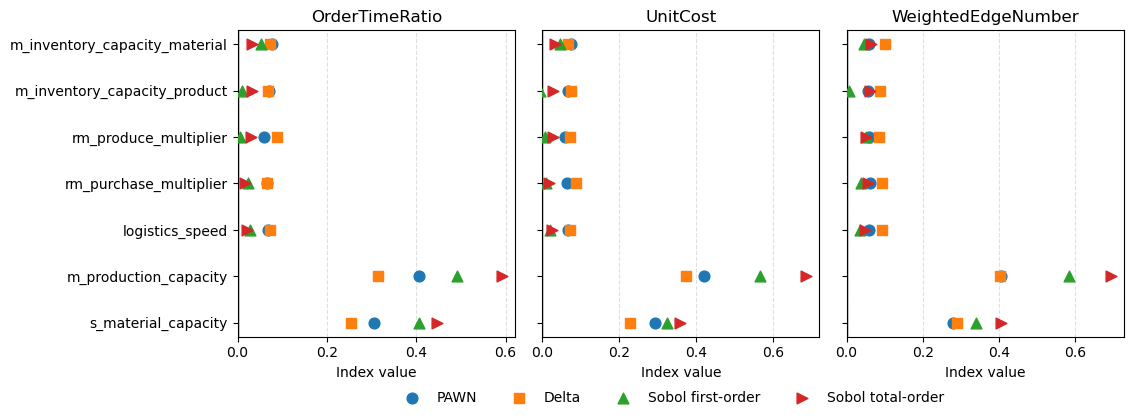

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ---------- 0-1  Sobol 结果 ----------
sobol_df = pd.DataFrame([
    # AvgWeightedEdge
    ("s_material_capacity",         0.340981, 0.406599,  "WeightedEdgeNumber"),
    ("m_production_capacity",       0.583503, 0.693826,  "WeightedEdgeNumber"),
    ("logistics_speed",             0.034129, 0.048840,  "WeightedEdgeNumber"),
    ("rm_purchase_multiplier",      0.036592, 0.056641,  "WeightedEdgeNumber"),
    ("rm_produce_multiplier",       0.052126, 0.050504,  "WeightedEdgeNumber"),
    ("m_inventory_capacity_product",0.007291, 0.062241,  "WeightedEdgeNumber"),
    ("m_inventory_capacity_material",0.044385,0.064955,  "WeightedEdgeNumber"),
    # FulfillmentRatio
    ("s_material_capacity",         0.406932, 0.446145,  "OrderTimeRatio"),
    ("m_production_capacity",       0.490465, 0.591411,  "OrderTimeRatio"),
    ("logistics_speed",             0.027604, 0.022110,  "OrderTimeRatio"),
    ("rm_purchase_multiplier",      0.022418, 0.017374,  "OrderTimeRatio"),
    ("rm_produce_multiplier",       0.004994, 0.029716,  "OrderTimeRatio"),
    ("m_inventory_capacity_product",0.010113, 0.031791,  "OrderTimeRatio"),
    ("m_inventory_capacity_material",0.052392,0.032249,  "OrderTimeRatio"),
    # UnitCost
    ("s_material_capacity",         0.326049, 0.359336,  "UnitCost"),
    ("m_production_capacity",       0.567526, 0.687139,  "UnitCost"),
    ("logistics_speed",             0.021067, 0.026196,  "UnitCost"),
    ("rm_purchase_multiplier",      0.009635, 0.018066,  "UnitCost"),
    ("rm_produce_multiplier",       0.006750, 0.027366,  "UnitCost"),
    ("m_inventory_capacity_product",-0.004874,0.028861,  "UnitCost"),
    ("m_inventory_capacity_material",0.045305,0.034277,  "UnitCost"),
], columns=["parameter", "S1", "ST", "metric"])

# ---------- 0-2  Delta + PAWN 结果 ----------
gsa_tbl = pd.DataFrame([
    # --- AvgEdge ---
    ("s_material_capacity", "Delta", "delta", 0.288699, "WeightedEdgeNumber"),
    ("m_production_capacity","Delta", "delta", 0.401888, "WeightedEdgeNumber"),
    ("logistics_speed",      "Delta", "delta", 0.093877, "WeightedEdgeNumber"),
    ("rm_purchase_multiplier","Delta","delta", 0.092323, "WeightedEdgeNumber"),
    ("rm_produce_multiplier","Delta", "delta", 0.085133, "WeightedEdgeNumber"),
    ("m_inventory_capacity_product","Delta","delta",0.088085,"WeightedEdgeNumber"),
    ("m_inventory_capacity_material","Delta","delta",0.101844,"WeightedEdgeNumber"),
    ("s_material_capacity", "PAWN", "p_mean", 0.280107, "WeightedEdgeNumber"),
    ("m_production_capacity","PAWN","p_mean", 0.405927, "WeightedEdgeNumber"),
    ("logistics_speed",      "PAWN","p_mean", 0.058021, "WeightedEdgeNumber"),
    ("rm_purchase_multiplier","PAWN","p_mean", 0.060125, "WeightedEdgeNumber"),
    ("rm_produce_multiplier","PAWN","p_mean", 0.059201, "WeightedEdgeNumber"),
    ("m_inventory_capacity_product","PAWN","p_mean",0.057209,"WeightedEdgeNumber"),
    ("m_inventory_capacity_material","PAWN","p_mean",0.059591,"WeightedEdgeNumber"),
    # --- FulfillRatio ---
    ("s_material_capacity", "Delta","delta", 0.253058, "OrderTimeRatio"),
    ("m_production_capacity","Delta","delta", 0.315224, "OrderTimeRatio"),
    ("logistics_speed",      "Delta","delta", 0.073108, "OrderTimeRatio"),
    ("rm_purchase_multiplier","Delta","delta", 0.065077, "OrderTimeRatio"),
    ("rm_produce_multiplier","Delta","delta", 0.088098, "OrderTimeRatio"),
    ("m_inventory_capacity_product","Delta","delta",0.068359,"OrderTimeRatio"),
    ("m_inventory_capacity_material","Delta","delta",0.072280,"OrderTimeRatio"),
    ("s_material_capacity", "PAWN","p_mean", 0.305609, "OrderTimeRatio"),
    ("m_production_capacity","PAWN","p_mean", 0.405672, "OrderTimeRatio"),
    ("logistics_speed",      "PAWN","p_mean", 0.068561, "OrderTimeRatio"),
    ("rm_purchase_multiplier","PAWN","p_mean", 0.066763, "OrderTimeRatio"),
    ("rm_produce_multiplier","PAWN","p_mean", 0.058773, "OrderTimeRatio"),
    ("m_inventory_capacity_product","PAWN","p_mean",0.070870,"OrderTimeRatio"),
    ("m_inventory_capacity_material","PAWN","p_mean",0.076341,"OrderTimeRatio"),
    # --- UnitCost ---
    ("s_material_capacity", "Delta","delta", 0.228031, "UnitCost"),
    ("m_production_capacity","Delta","delta", 0.374959, "UnitCost"),
    ("logistics_speed",      "Delta","delta", 0.073054, "UnitCost"),
    ("rm_purchase_multiplier","Delta","delta", 0.087796, "UnitCost"),
    ("rm_produce_multiplier","Delta","delta", 0.073584, "UnitCost"),
    ("m_inventory_capacity_product","Delta","delta",0.075477,"UnitCost"),
    ("m_inventory_capacity_material","Delta","delta",0.068126,"UnitCost"),
    ("s_material_capacity", "PAWN","p_mean", 0.294602, "UnitCost"),
    ("m_production_capacity","PAWN","p_mean", 0.421172, "UnitCost"),
    ("logistics_speed",      "PAWN","p_mean", 0.067518, "UnitCost"),
    ("rm_purchase_multiplier","PAWN","p_mean", 0.063633, "UnitCost"),
    ("rm_produce_multiplier","PAWN","p_mean", 0.058748, "UnitCost"),
    ("m_inventory_capacity_product","PAWN","p_mean",0.066678,"UnitCost"),
    ("m_inventory_capacity_material","PAWN","p_mean",0.075448,"UnitCost"),
], columns=["parameter","method","index","value","metric"])

# ------------------------------------------------------------
# 1) 整形 – 把 Sobol 指数转换成长表并与 GSA 指标合并
# ------------------------------------------------------------
sobol_long = (
    sobol_df
      .melt(id_vars=["parameter","metric"],
            value_vars=["S1","ST"],
            var_name="method", value_name="value")
      .assign(method=lambda d: d["method"].map(
          {"S1":"Sobol first-order","ST":"Sobol total-order"}))
)[["parameter","metric","method","value"]]

plot_df = pd.concat([sobol_long, gsa_tbl], ignore_index=True)

# ------------------------------------------------------------
# 2) 排序 – 让参数、方法顺眼一点
# ------------------------------------------------------------
param_order  = plot_df["parameter"].unique()[::-1]   # 参数反转一下 ↑
method_order = ["PAWN","Delta","Sobol first-order","Sobol total-order"]

plot_df["parameter"] = pd.Categorical(plot_df["parameter"],
                                      categories=param_order, ordered=True)
plot_df["method"]    = pd.Categorical(plot_df["method"],
                                      categories=method_order, ordered=True)

# 调色 & marker
palette = {"PAWN": "#1f77b4",
           "Delta": "#ff7f0e",
           "Sobol first-order": "#2ca02c",
           "Sobol total-order": "#d62728"}
markers = {"PAWN":"o","Delta":"s",
           "Sobol first-order":"^","Sobol total-order":">"}

# ------------------------------------------------------------
# 3) 画图
# ------------------------------------------------------------
n_metrics = plot_df["metric"].nunique()
fig, axes = plt.subplots(1, n_metrics, figsize=(13,4), sharey=True)

if n_metrics == 1:    # 只有一个指标时 axes 不是列表
    axes = [axes]

for ax, (metric, sub) in zip(axes, plot_df.groupby("metric")):
    ax.axvline(0, color="k", lw=1)                     # 基准线
    for mth, grp in sub.groupby("method"):
        ax.scatter(grp["value"], grp["parameter"],
                   label=mth, color=palette[mth],
                   marker=markers[mth], s=60, zorder=3)
    ax.set_title(metric)
    ax.set_xlabel("Index value")
    ax.set_xlim(left=0)
    ax.grid(axis="x", linestyle="--", alpha=.4)
    if ax is axes[0]:
        ax.set_ylabel("")   # y 轴 tick 本身已含参数名
    else:
        ax.set_ylabel("")

# 统一图例
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.52, -.055),  loc="lower center", ncol=len(labels), frameon=False)
fig.tight_layout(rect=[0,0,0.88,1])
plt.show()

In [16]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import sobol
from SALib.analyze.sobol import analyze      # sobol 仍然是一个“模块”
def _to_scalar(x):
    """确保传入 int()/float() 的一定是 Python 标量"""
    if isinstance(x, np.ndarray):
        return x.item()
    return x

def eval_static(base_params: dict, override_params: dict):
    """
    1 次仿真，返回 (平均边权, 履约率, 单位成本) 三指标
    （如有更多指标，可以相应地修改代码）
    """
    # ---------- 1) 默认参数 ----------
    all_params = dict(
        cust_demand_multiplier          = 1.0,
        m_production_capacity           = 230,
        m_inventory_capacity_product    = 700,
        m_inventory_capacity_material   = 1000,
        s_material_capacity             = 200,
        agent_mode                      = "heterogeneous",
        logistics_speed                 = 1000.0,
        rm_procurement_mode             = "gap_based",
        rm_reorder_point                = 400,
        rm_reorder_target               = 900,
        rm_purchase_multiplier          = 1.2,
        rm_produce_multiplier           = 1.2,
        product_order_mode              = "normal",
        material_order_mode             = "normal",
        total_steps                     = 1000,
        num_reps                        = 1,
        change_schedule                 = None,
        return_model                    = True,
    )

    # ---------- 2) 覆盖参数 ----------
    all_params.update({k: _to_scalar(v) for k, v in base_params.items()})
    all_params.update({k: _to_scalar(v) for k, v in override_params.items()})

    # ---------- 3) 仅“需要整数”的键做强制取整 ----------
    int_keys = [
        "s_material_capacity",
        "m_production_capacity",
    ]
    for k in int_keys:
        if k in all_params:
            all_params[k] = max(1, int(round(all_params[k])))

    # ---------- 4) 调用仿真 ----------
    _, (
        mean_edge, _,
        mean_ratio, _,
        mean_uc,   _
    ) = run_simulation_with_param_changes(**all_params)

    return np.mean(mean_edge), np.mean(mean_ratio), np.mean(mean_uc)


# ===========================================================
# 3) Sobol “problem” 设置
# ===========================================================
problem = {
    "num_vars": 2,
    "names": [
        "s_material_capacity",
        "m_production_capacity",

    ],
    "bounds": [
        [10,   1000],   # int
        [10,   1000],   # int

    ],
}

# ===========================================================
# 4) Saltelli–Sobol 采样
# ===========================================================
N_BASE = 2                      # 示范用小样本；实际请加大 N_BASE
np.random.seed(42)
param_values = sobol.sample(problem, N_BASE, calc_second_order=True)
print(f"Total simulations needed: {param_values.shape[0]}")

# ===========================================================
# 5) 运行模型
# ===========================================================
def run_one_sim(sample_row):
    override = {k: v for k, v in zip(problem["names"], sample_row)}
    try:
        return eval_static({}, override)
    except Exception as e:
        # 打印更友好的日志，同时返回 nan，方便后续过滤
        print(f"[WARN] sim failed with params {override} -> {e}")
        return np.nan, np.nan, np.nan

results = []
for row in tqdm(param_values, desc="Running model"):
    results.append(run_one_sim(row))
Y = np.array(results, dtype=float)          # shape = (samples, 3)

# 如果某些仿真失败，用 nan 作标记，Sobol 不接受 nan，需要先剔除
mask = ~np.isnan(Y).any(axis=1)
if mask.sum() < Y.shape[0]:
    print(f"[INFO] filtered out {Y.shape[0]-mask.sum()} failed runs")
Y = Y[mask]
param_values_valid = param_values[mask]

# ===========================================================
# 6) Sobol 方差分解 & 保存
# ===========================================================
def sobol_df(y, metric):
    Si = analyze(problem, y, calc_second_order=True, print_to_console=False)
    return (
        pd.DataFrame({
            "parameter": problem["names"],
            "S1":  Si["S1"],
            "ST":  Si["ST"]
        })
        .assign(metric=metric)
    )

full_table = pd.concat([
    sobol_df(Y[:, 0], "AvgWeightedEdge"),
    sobol_df(Y[:, 1], "FulfillmentRatio"),
    sobol_df(Y[:, 2], "UnitCost"),
], ignore_index=True)

print(full_table)
full_table.to_csv("sobol_indices.csv", index=False)
print("Sobol results saved → sobol_indices.csv")

Total simulations needed: 12


Running model: 100%|███████████████████████████████████████████████████████████████████| 12/12 [03:38<00:00, 18.22s/it]

               parameter        S1        ST            metric
0    s_material_capacity  0.712305  0.743781   AvgWeightedEdge
1  m_production_capacity  0.478920  0.539364   AvgWeightedEdge
2    s_material_capacity  0.206295  0.310415  FulfillmentRatio
3  m_production_capacity  0.438283  1.376210  FulfillmentRatio
4    s_material_capacity  0.222551  0.385826          UnitCost
5  m_production_capacity  0.421372  1.384197          UnitCost
Sobol results saved → sobol_indices.csv



D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
D:\python\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
